In [52]:
# OpenMiChroM simulation module
from OpenMiChroM.ChromDynamics import MiChroM
# Optimization of MiChroM parameters module
from OpenMiChroM.Optimization import CustomMiChroMTraining
# Analysis tools module
from OpenMiChroM.CndbTools import cndbTools

# Extra modules to load and plot .dense file
import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn.preprocessing import normalize
import numpy as np
import pandas as pd
import h5py
from scipy.optimize import curve_fit

import os.path as osp
from pylib.utils import epilib
import os
import csv

wd = '/home/erschultz/OpenMiChroM/Tutorials/MiChroM_Optimization'

[[1.00000000e+00 1.32126161e-01 6.88074840e-02 ... 3.20234487e-04
  3.18772556e-04 0.00000000e+00]
 [1.32126161e-01 1.00000000e+00 1.71223650e-01 ... 0.00000000e+00
  5.30216981e-04 1.24062059e-04]
 [6.88074840e-02 1.71223650e-01 1.00000000e+00 ... 1.18784152e-04
  3.18866316e-04 3.20867925e-04]
 ...
 [3.20234487e-04 0.00000000e+00 1.18784152e-04 ... 1.00000000e+00
  4.62619795e-01 1.92040887e-01]
 [3.18772556e-04 5.30216981e-04 3.18866316e-04 ... 4.62619795e-01
  1.00000000e+00 4.76849433e-01]
 [0.00000000e+00 1.24062059e-04 3.20867925e-04 ... 1.92040887e-01
  4.76849433e-01 1.00000000e+00]]
number of beads:  512


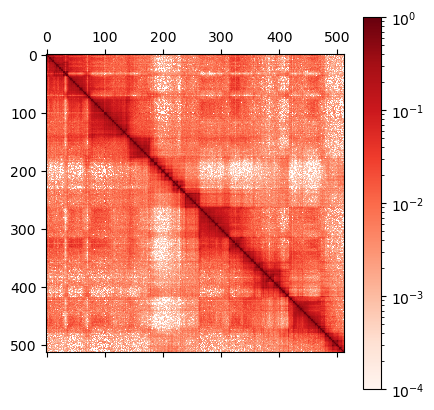

In [80]:
dir = '/home/erschultz/dataset_11_20_23/samples/sample8'
odir = osp.join(dir, 'michrom')
if not osp.exists(odir):
    os.mkdir(odir, mode=0o755)
hic_file = np.load(osp.join(dir, 'y.npy'))
hic_file /= np.mean(hic_file.diagonal())
np.fill_diagonal(hic_file, 1)
print(hic_file)
m=len(hic_file)
y_dense = osp.join(odir, 'y_dense.txt')
np.savetxt(y_dense, hic_file)

r=np.triu(hic_file, k=1)
r[np.isnan(r)]= 0.0
r = normalize(r, axis=1, norm='max')
rd = np.transpose(r)
r=r+rd + np.diag(np.ones(len(r)))
print("number of beads: ", len(r))
plt.matshow(r,norm=mpl.colors.LogNorm(vmin=0.0001, vmax=r.max()),cmap="Reds")
plt.colorbar()

In [39]:
eigen = np.loadtxt(osp.join(wd, "input/chr10_100k.eigen"))
print(eigen, )

[ 0.01286464 -0.00912715 -0.01848022 ... -0.00151743  0.00030191
  0.00551016]


In [56]:
eigen = epilib.get_sequences(hic_file, 1, randomized=True)[0]
print(eigen[:10], eigen.shape)
labels = []
for i, val in enumerate(eigen):
    if val > 0:
        labels.append('B1')
    else:
        labels.append('A1')

bead_file = osp.join(odir, 'beads.txt')
with open(bead_file, 'w', newline = '') as f:
    wr = csv.writer(f, delimiter = '\t')
    wr.writerows(zip(np.arange(1, m+1), labels))

getting sequences with RANDOMIZED SVD
[0.61386129 0.88696724 0.88701282 0.88770047 0.58360472 0.09156221
 0.8587898  0.92722324 0.88432205 0.91938322] (512,)


Number of beads: A1 =  177 , B1 =  335


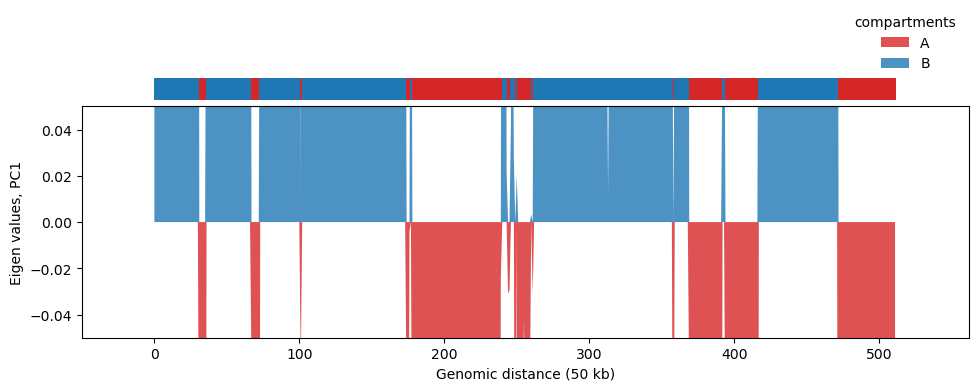

In [46]:
index = np.arange(eigen.size)
df = pd.Series(eigen, index=index)

A1_df = pd.Series(np.zeros(eigen.size), index=index)
A1_df[df < 0] = df[df < 0]
B1_df = pd.Series(np.zeros(eigen.size), index=index)
B1_df[df > 0] = df[df > 0]

NA_df = df.isna()
# y = sc.signal.savgol_filter(A1,20, 2)

fig, axes = plt.subplots(ncols=1, nrows=2,
                         figsize=(6.4*3/2, 4.8*2/3),
                         gridspec_kw={'height_ratios': [1, 10]})
fig.tight_layout()

fig.subplots_adjust(hspace=0.05) # top=0.92, bottom=0.01, wspace=0.)

# sequence
A11_df = A1_df.copy()
A11_df[A1_df<0] = 1
B11_df = B1_df.copy()
B11_df[B1_df>0] = 1

axes[0].axis('off')
width=1
axes[0].bar(A11_df.index, A11_df,
       width,
       color="tab:red")
axes[0].bar(B11_df.index, B11_df,
       width,
       color="tab:blue")

axes[0].set_xlim([-50,eigen.size + 50])

# Eigen PC1
step=1
axes[1].fill_between(A1_df.index[::step], A1_df[::step],  0,
                facecolor="tab:red",
                alpha=0.8,
                label="A")
axes[1].fill_between(B1_df.index[::step], B1_df[::step],  0,
                facecolor="tab:blue",
                alpha=0.8,
                label="B")

axes[1].set_ylim([-0.05,0.05])
axes[1].set_xlim([-50,eigen.size + 50])

axes[1].set_ylabel('Eigen values, PC1')
axes[1].set_xlabel('Genomic distance (50 kb)')

axes[1].legend(title='compartments', bbox_to_anchor=(1.,1.45),
               frameon=False)

print("Number of beads: A1 = ", A1_df[A1_df<0].shape[0],
      ", B1 = ", B1_df[B1_df>0].shape[0])

In [57]:
simulation = MiChroM(name='opt_chr10_100K', temperature=1.0, time_step=0.01)
simulation.setup(platform="cuda")
simulation.saveFolder(osp.join(odir, 'iteration_0'))

    ***************************************************************************************     
     **** **** *** *** *** *** *** *** OpenMiChroM-1.0.7 *** *** *** *** *** *** **** ****      

         OpenMiChroM is a Python library for performing chromatin dynamics simulations.         
                            OpenMiChroM uses the OpenMM Python API,                             
                employing the MiChroM (Minimal Chromatin Model) energy function.                
      The chromatin dynamics simulations generate an ensemble of 3D chromosomal structures      
      that are consistent with experimental Hi-C maps, also allows simulations of a single      
                 or multiple chromosome chain using High-Performance Computing                  
                            in different platforms (GPUs and CPUs).                             
         OpenMiChroM documentation is available at https://open-michrom.readthedocs.io          

         OpenMiChroM is desc

In [60]:
mychro = simulation.createSpringSpiral(ChromSeq=bead_file)
simulation.loadStructure(mychro, center=True)

# homo
simulation.addFENEBonds(kfb=30.0)
simulation.addAngles(ka=2.0)
simulation.addRepulsiveSoftCore(Ecut=4.0)

simulation.addCustomTypes(mu=3.22, rc = 1.78, TypesTable=osp.join(wd, 'input/lambda_0'))
simulation.addFlatBottomHarmonic(kr=5*10**-3, n_rad=8.0)

In [61]:
block    = 1000
n_blocks = 100
rg = []
for _ in range(n_blocks):
    simulation.runSimBlock(block, increment=False)
    rg.append(simulation.chromRG())

#save a collapsed structure in pdb format for inspection
simulation.saveStructure(mode = 'pdb')

Number of exceptions: 1022
adding force  FENEBond 0
adding force  AngleForce 1
Add exclusions for RepulsiveSoftCore force
adding force  RepulsiveSoftCore 2
Add exclusions for CustomTypes force
adding force  CustomTypes 3
adding force  FlatBottomHarmonic 4
Positions... 
 loaded!
potential energy is 41.755268
bl=0 pos[1]=[39.6 -0.6 6.1] dr=2.89 t=10.0ps kin=1.31 pot=42.20 Rg=26.715 SPS=4202 
bl=0 pos[1]=[32.0 -1.0 9.5] dr=2.32 t=20.0ps kin=1.39 pot=42.35 Rg=25.752 SPS=21541 
bl=0 pos[1]=[29.2 -4.0 9.3] dr=2.25 t=30.0ps kin=1.56 pot=42.27 Rg=24.843 SPS=22400 
bl=0 pos[1]=[28.0 -3.1 7.4] dr=2.14 t=40.0ps kin=1.49 pot=42.29 Rg=24.135 SPS=22533 
bl=0 pos[1]=[28.3 -3.9 6.6] dr=2.15 t=50.0ps kin=1.54 pot=42.23 Rg=23.256 SPS=23777 
bl=0 pos[1]=[27.7 -4.7 5.7] dr=1.99 t=60.0ps kin=1.49 pot=42.14 Rg=22.489 SPS=23280 
bl=0 pos[1]=[25.2 -3.7 5.4] dr=1.94 t=70.0ps kin=1.50 pot=42.18 Rg=21.710 SPS=24352 
bl=0 pos[1]=[24.0 -1.7 4.0] dr=1.99 t=80.0ps kin=1.54 pot=42.00 Rg=21.068 SPS=23118 
bl=0 pos[1]=

bl=0 pos[1]=[4.3 1.6 -2.6] dr=1.86 t=940.0ps kin=1.52 pot=41.73 Rg=9.849 SPS=19632 
bl=0 pos[1]=[4.2 0.9 -4.3] dr=1.93 t=950.0ps kin=1.52 pot=41.69 Rg=9.710 SPS=20008 
bl=0 pos[1]=[3.3 0.9 -1.4] dr=1.88 t=960.0ps kin=1.54 pot=41.71 Rg=9.542 SPS=19719 
bl=0 pos[1]=[2.8 3.4 1.0] dr=1.95 t=970.0ps kin=1.55 pot=41.65 Rg=9.481 SPS=20150 
bl=0 pos[1]=[3.7 3.7 -0.5] dr=2.03 t=980.0ps kin=1.55 pot=41.68 Rg=9.493 SPS=19892 
bl=0 pos[1]=[3.3 3.8 -1.2] dr=1.96 t=990.0ps kin=1.47 pot=41.70 Rg=9.522 SPS=20294 
bl=0 pos[1]=[0.6 2.5 -1.7] dr=1.86 t=1000.0ps kin=1.50 pot=41.66 Rg=9.576 SPS=20310 


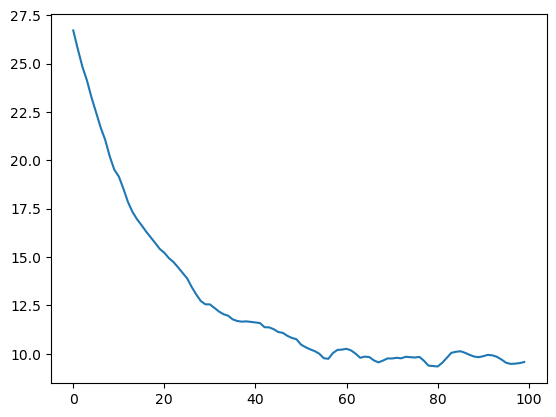

In [62]:
plt.plot(rg)

In [63]:
# Remove Flat initialized in Collapse
simulation.removeFlatBottomHarmonic()

# Add a confinement potential with density=0.1 (volume fraction)
simulation.addSphericalConfinementLJ()

Removed FlatBottomHarmonic from the system!


10.692037682047616

In [66]:
optimization = CustomMiChroMTraining(ChromSeq=bead_file,
                                     TypesTable=osp.join(wd, 'input/lambda_0'),
                                     mu=3.22, rc = 1.78)

In [67]:
block    = 1000
n_blocks = 5000

for _ in range(n_blocks):
    # perform 1 block of simulation
    simulation.runSimBlock(block, increment=True)

    # feed the optimization with the last chromosome configuration
    optimization.prob_calculation_types(simulation.getPositions())

bl=1 pos[1]=[2.4 2.6 -0.2] dr=1.92 t=1010.0ps kin=1.45 pot=41.66 Rg=9.468 SPS=14698 
bl=2 pos[1]=[3.7 2.1 0.2] dr=1.96 t=1020.0ps kin=1.46 pot=41.70 Rg=9.533 SPS=19543 
bl=3 pos[1]=[6.6 2.2 -1.6] dr=1.89 t=1030.0ps kin=1.47 pot=41.69 Rg=9.694 SPS=19974 
bl=4 pos[1]=[3.8 3.0 -2.6] dr=1.89 t=1040.0ps kin=1.45 pot=41.69 Rg=9.853 SPS=19002 
bl=5 pos[1]=[3.0 0.9 -0.7] dr=1.76 t=1050.0ps kin=1.50 pot=41.73 Rg=9.890 SPS=19684 
bl=6 pos[1]=[1.9 -1.0 -0.4] dr=1.85 t=1060.0ps kin=1.50 pot=41.74 Rg=9.894 SPS=20848 
bl=7 pos[1]=[1.6 -2.8 -2.3] dr=1.83 t=1070.0ps kin=1.44 pot=41.69 Rg=10.023 SPS=20430 
bl=8 pos[1]=[0.5 -2.4 -3.5] dr=1.89 t=1080.0ps kin=1.48 pot=41.68 Rg=10.158 SPS=20843 
bl=9 pos[1]=[1.4 -0.9 -4.7] dr=1.83 t=1090.0ps kin=1.54 pot=41.69 Rg=10.306 SPS=20631 
bl=10 pos[1]=[1.4 -3.0 -5.0] dr=1.91 t=1100.0ps kin=1.49 pot=41.71 Rg=10.463 SPS=21171 
bl=11 pos[1]=[-0.1 -5.6 -2.8] dr=1.96 t=1110.0ps kin=1.51 pot=41.65 Rg=10.433 SPS=21302 
bl=12 pos[1]=[0.1 -3.8 -0.9] dr=1.94 t=1120.0ps kin=

bl=82 pos[1]=[10.9 -1.4 -9.7] dr=1.96 t=1820.0ps kin=1.47 pot=41.67 Rg=12.951 SPS=20371 
bl=83 pos[1]=[9.7 0.3 -8.7] dr=1.84 t=1830.0ps kin=1.50 pot=41.63 Rg=12.999 SPS=20658 
bl=84 pos[1]=[7.6 -2.8 -9.1] dr=1.99 t=1840.0ps kin=1.57 pot=41.69 Rg=13.013 SPS=19208 
bl=85 pos[1]=[8.3 -3.9 -10.0] dr=1.94 t=1850.0ps kin=1.52 pot=41.71 Rg=12.922 SPS=19100 
bl=86 pos[1]=[6.6 -5.3 -9.3] dr=1.92 t=1860.0ps kin=1.50 pot=41.68 Rg=12.877 SPS=20102 
bl=87 pos[1]=[5.9 -5.2 -8.3] dr=1.91 t=1870.0ps kin=1.44 pot=41.70 Rg=12.884 SPS=19375 
bl=88 pos[1]=[8.2 -2.5 -7.0] dr=1.91 t=1880.0ps kin=1.50 pot=41.63 Rg=13.006 SPS=19096 
bl=89 pos[1]=[10.6 -1.6 -7.9] dr=1.93 t=1890.0ps kin=1.45 pot=41.66 Rg=13.030 SPS=18876 
bl=90 pos[1]=[8.1 0.3 -9.6] dr=2.02 t=1900.0ps kin=1.51 pot=41.65 Rg=12.846 SPS=19858 
bl=91 pos[1]=[9.3 0.5 -8.5] dr=1.97 t=1910.0ps kin=1.46 pot=41.63 Rg=12.788 SPS=21059 
bl=92 pos[1]=[9.9 1.3 -8.8] dr=1.90 t=1920.0ps kin=1.49 pot=41.64 Rg=12.726 SPS=19057 
bl=93 pos[1]=[13.5 0.6 -7.5] dr=1

bl=150 pos[1]=[6.2 -4.2 -12.9] dr=1.91 t=2500.0ps kin=1.41 pot=41.65 Rg=13.588 SPS=19724 
bl=151 pos[1]=[5.6 -4.7 -12.0] dr=1.91 t=2510.0ps kin=1.46 pot=41.59 Rg=13.591 SPS=18257 
bl=152 pos[1]=[3.4 -3.7 -13.0] dr=1.81 t=2520.0ps kin=1.38 pot=41.63 Rg=13.717 SPS=19506 
bl=153 pos[1]=[1.6 -2.0 -13.5] dr=1.88 t=2530.0ps kin=1.50 pot=41.61 Rg=13.709 SPS=18273 
bl=154 pos[1]=[1.4 -0.4 -15.8] dr=1.96 t=2540.0ps kin=1.50 pot=41.64 Rg=13.808 SPS=18261 
bl=155 pos[1]=[2.9 2.2 -17.8] dr=1.88 t=2550.0ps kin=1.55 pot=41.62 Rg=13.861 SPS=19788 
bl=156 pos[1]=[2.0 4.6 -16.4] dr=1.86 t=2560.0ps kin=1.52 pot=41.69 Rg=13.804 SPS=19860 
bl=157 pos[1]=[0.6 4.7 -15.1] dr=1.90 t=2570.0ps kin=1.52 pot=41.69 Rg=13.730 SPS=18641 
bl=158 pos[1]=[2.7 5.8 -15.5] dr=1.83 t=2580.0ps kin=1.57 pot=41.69 Rg=13.756 SPS=19820 
bl=159 pos[1]=[5.0 3.5 -17.4] dr=1.82 t=2590.0ps kin=1.51 pot=41.69 Rg=13.860 SPS=20121 
bl=160 pos[1]=[4.2 1.0 -14.9] dr=1.91 t=2600.0ps kin=1.49 pot=41.65 Rg=13.830 SPS=20492 
bl=161 pos[1]=[2

bl=230 pos[1]=[-7.4 -9.3 -4.6] dr=1.91 t=3300.0ps kin=1.56 pot=41.71 Rg=13.532 SPS=20139 
bl=231 pos[1]=[-6.3 -8.4 -5.1] dr=1.95 t=3310.0ps kin=1.47 pot=41.69 Rg=13.595 SPS=21715 
bl=232 pos[1]=[-6.3 -10.0 -4.2] dr=1.95 t=3320.0ps kin=1.48 pot=41.68 Rg=13.752 SPS=21264 
bl=233 pos[1]=[-3.8 -10.9 -3.8] dr=1.92 t=3330.0ps kin=1.48 pot=41.60 Rg=13.887 SPS=18626 
bl=234 pos[1]=[-4.3 -10.1 -3.6] dr=1.87 t=3340.0ps kin=1.49 pot=41.56 Rg=14.067 SPS=19668 
bl=235 pos[1]=[-2.7 -9.1 -3.6] dr=1.96 t=3350.0ps kin=1.49 pot=41.63 Rg=14.323 SPS=18795 
bl=236 pos[1]=[-1.8 -9.6 -4.8] dr=1.94 t=3360.0ps kin=1.48 pot=41.62 Rg=14.323 SPS=19544 
bl=237 pos[1]=[-1.5 -10.0 -6.7] dr=2.00 t=3370.0ps kin=1.50 pot=41.63 Rg=14.249 SPS=19793 
bl=238 pos[1]=[-1.3 -10.2 -7.0] dr=2.04 t=3380.0ps kin=1.51 pot=41.59 Rg=14.049 SPS=19096 
bl=239 pos[1]=[-3.0 -11.6 -5.4] dr=1.90 t=3390.0ps kin=1.58 pot=41.59 Rg=13.775 SPS=20705 
bl=240 pos[1]=[-0.7 -11.9 -6.1] dr=1.99 t=3400.0ps kin=1.50 pot=41.70 Rg=13.482 SPS=21430 
bl=

bl=300 pos[1]=[2.4 7.6 0.1] dr=1.91 t=4000.0ps kin=1.59 pot=41.65 Rg=13.213 SPS=19479 
bl=301 pos[1]=[3.6 5.3 1.4] dr=2.00 t=4010.0ps kin=1.50 pot=41.67 Rg=13.060 SPS=19839 
bl=302 pos[1]=[4.1 6.3 -1.6] dr=2.04 t=4020.0ps kin=1.50 pot=41.64 Rg=13.178 SPS=22581 
bl=303 pos[1]=[4.7 5.2 -3.9] dr=1.98 t=4030.0ps kin=1.55 pot=41.62 Rg=13.233 SPS=22473 
bl=304 pos[1]=[6.7 4.9 -4.6] dr=1.95 t=4040.0ps kin=1.45 pot=41.70 Rg=13.095 SPS=22562 
bl=305 pos[1]=[9.2 1.9 -4.1] dr=2.04 t=4050.0ps kin=1.57 pot=41.67 Rg=13.134 SPS=21482 
bl=306 pos[1]=[9.5 5.0 -3.4] dr=1.97 t=4060.0ps kin=1.57 pot=41.72 Rg=13.033 SPS=20680 
bl=307 pos[1]=[9.1 7.0 -4.6] dr=1.91 t=4070.0ps kin=1.53 pot=41.65 Rg=12.952 SPS=21495 
bl=308 pos[1]=[6.5 10.4 -3.3] dr=1.98 t=4080.0ps kin=1.46 pot=41.59 Rg=12.977 SPS=20500 
bl=309 pos[1]=[9.1 9.9 -0.3] dr=1.96 t=4090.0ps kin=1.55 pot=41.62 Rg=13.077 SPS=21597 
bl=310 pos[1]=[10.4 5.8 -1.6] dr=1.92 t=4100.0ps kin=1.50 pot=41.54 Rg=12.966 SPS=22350 
bl=311 pos[1]=[11.1 4.4 -0.8] dr

bl=380 pos[1]=[9.0 5.6 -9.0] dr=1.94 t=4800.0ps kin=1.57 pot=41.67 Rg=14.673 SPS=20107 
bl=381 pos[1]=[8.2 3.5 -10.5] dr=1.99 t=4810.0ps kin=1.48 pot=41.61 Rg=14.584 SPS=20588 
bl=382 pos[1]=[9.1 3.6 -11.4] dr=1.92 t=4820.0ps kin=1.55 pot=41.61 Rg=14.628 SPS=20953 
bl=383 pos[1]=[8.2 3.5 -8.8] dr=1.81 t=4830.0ps kin=1.44 pot=41.74 Rg=14.614 SPS=20639 
bl=384 pos[1]=[7.8 4.8 -8.6] dr=1.92 t=4840.0ps kin=1.57 pot=41.68 Rg=14.633 SPS=21660 
bl=385 pos[1]=[7.3 5.7 -11.3] dr=2.01 t=4850.0ps kin=1.51 pot=41.56 Rg=14.700 SPS=20560 
bl=386 pos[1]=[7.4 5.8 -10.2] dr=1.95 t=4860.0ps kin=1.48 pot=41.67 Rg=14.979 SPS=21346 
bl=387 pos[1]=[3.6 7.3 -7.3] dr=1.90 t=4870.0ps kin=1.56 pot=41.60 Rg=15.160 SPS=21922 
bl=388 pos[1]=[3.1 8.6 -8.4] dr=2.00 t=4880.0ps kin=1.55 pot=41.64 Rg=15.219 SPS=20322 
bl=389 pos[1]=[3.6 9.7 -5.6] dr=1.81 t=4890.0ps kin=1.39 pot=41.64 Rg=15.094 SPS=21603 
bl=390 pos[1]=[4.8 9.1 -4.8] dr=1.92 t=4900.0ps kin=1.44 pot=41.64 Rg=15.014 SPS=20906 
bl=391 pos[1]=[4.6 8.4 -4.9]

bl=450 pos[1]=[20.4 2.7 -12.9] dr=1.88 t=5500.0ps kin=1.57 pot=41.58 Rg=16.772 SPS=21043 
bl=451 pos[1]=[19.9 2.2 -14.0] dr=1.93 t=5510.0ps kin=1.46 pot=41.65 Rg=16.950 SPS=21244 
bl=452 pos[1]=[18.2 3.2 -12.3] dr=1.92 t=5520.0ps kin=1.48 pot=41.71 Rg=17.181 SPS=21372 
bl=453 pos[1]=[16.7 7.9 -13.2] dr=2.02 t=5530.0ps kin=1.61 pot=41.62 Rg=17.375 SPS=20153 
bl=454 pos[1]=[16.4 7.2 -14.8] dr=1.86 t=5540.0ps kin=1.55 pot=41.67 Rg=17.450 SPS=19734 
bl=455 pos[1]=[15.4 10.5 -16.9] dr=1.87 t=5550.0ps kin=1.59 pot=41.69 Rg=17.564 SPS=20707 
bl=456 pos[1]=[16.3 10.7 -19.2] dr=1.94 t=5560.0ps kin=1.44 pot=41.61 Rg=17.422 SPS=19428 
bl=457 pos[1]=[17.2 11.5 -20.0] dr=1.96 t=5570.0ps kin=1.44 pot=41.72 Rg=17.318 SPS=20290 
bl=458 pos[1]=[21.9 8.6 -20.5] dr=1.88 t=5580.0ps kin=1.51 pot=41.65 Rg=17.234 SPS=20337 
bl=459 pos[1]=[23.4 10.4 -17.9] dr=1.84 t=5590.0ps kin=1.57 pot=41.70 Rg=17.206 SPS=20493 
bl=460 pos[1]=[24.2 11.6 -16.3] dr=1.91 t=5600.0ps kin=1.51 pot=41.60 Rg=17.238 SPS=20210 
bl=46

bl=529 pos[1]=[25.2 18.8 -13.8] dr=2.02 t=6290.0ps kin=1.50 pot=41.66 Rg=18.068 SPS=20263 
bl=530 pos[1]=[27.4 17.7 -14.3] dr=1.82 t=6300.0ps kin=1.48 pot=41.63 Rg=18.160 SPS=22027 
bl=531 pos[1]=[28.5 16.4 -12.9] dr=1.91 t=6310.0ps kin=1.45 pot=41.70 Rg=18.318 SPS=22326 
bl=532 pos[1]=[32.1 15.2 -8.4] dr=1.89 t=6320.0ps kin=1.41 pot=41.63 Rg=18.123 SPS=23810 
bl=533 pos[1]=[32.0 15.6 -8.7] dr=1.82 t=6330.0ps kin=1.40 pot=41.72 Rg=17.926 SPS=21362 
bl=534 pos[1]=[32.9 12.4 -7.2] dr=1.93 t=6340.0ps kin=1.54 pot=41.57 Rg=18.010 SPS=22131 
bl=535 pos[1]=[32.0 10.8 -6.4] dr=1.96 t=6350.0ps kin=1.57 pot=41.62 Rg=17.998 SPS=22164 
bl=536 pos[1]=[28.5 9.8 -5.3] dr=1.94 t=6360.0ps kin=1.56 pot=41.65 Rg=17.950 SPS=22406 
bl=537 pos[1]=[29.1 10.1 -5.6] dr=1.98 t=6370.0ps kin=1.51 pot=41.63 Rg=18.087 SPS=22888 
bl=538 pos[1]=[28.6 11.2 -2.6] dr=2.07 t=6380.0ps kin=1.43 pot=41.66 Rg=18.063 SPS=23071 
bl=539 pos[1]=[26.6 12.7 -2.3] dr=1.96 t=6390.0ps kin=1.52 pot=41.60 Rg=18.199 SPS=23838 
bl=540 p

bl=600 pos[1]=[33.5 22.7 4.0] dr=1.95 t=7000.0ps kin=1.56 pot=41.64 Rg=18.714 SPS=21478 
bl=601 pos[1]=[31.8 20.0 5.0] dr=1.93 t=7010.0ps kin=1.54 pot=41.68 Rg=18.786 SPS=22547 
bl=602 pos[1]=[31.1 18.7 4.8] dr=1.98 t=7020.0ps kin=1.47 pot=41.70 Rg=18.908 SPS=21932 
bl=603 pos[1]=[31.2 19.3 5.2] dr=1.90 t=7030.0ps kin=1.52 pot=41.63 Rg=19.086 SPS=20715 
bl=604 pos[1]=[34.0 16.7 4.0] dr=2.06 t=7040.0ps kin=1.59 pot=41.61 Rg=19.025 SPS=20451 
bl=605 pos[1]=[32.8 15.1 4.4] dr=1.95 t=7050.0ps kin=1.52 pot=41.63 Rg=19.105 SPS=19603 
bl=606 pos[1]=[33.3 13.7 2.5] dr=1.92 t=7060.0ps kin=1.50 pot=41.63 Rg=19.048 SPS=20809 
bl=607 pos[1]=[29.5 11.6 -0.9] dr=1.94 t=7070.0ps kin=1.47 pot=41.61 Rg=18.966 SPS=21937 
bl=608 pos[1]=[28.9 13.6 0.1] dr=1.84 t=7080.0ps kin=1.49 pot=41.65 Rg=18.976 SPS=23166 
bl=609 pos[1]=[31.2 15.4 1.6] dr=1.92 t=7090.0ps kin=1.58 pot=41.69 Rg=18.813 SPS=23357 
bl=610 pos[1]=[31.8 15.2 2.4] dr=1.89 t=7100.0ps kin=1.53 pot=41.72 Rg=18.847 SPS=22905 
bl=611 pos[1]=[34.0 

bl=680 pos[1]=[31.7 24.5 -1.9] dr=1.89 t=7800.0ps kin=1.54 pot=41.66 Rg=19.050 SPS=21143 
bl=681 pos[1]=[33.3 24.0 -2.3] dr=1.94 t=7810.0ps kin=1.52 pot=41.62 Rg=19.120 SPS=20232 
bl=682 pos[1]=[34.6 26.2 -2.9] dr=1.93 t=7820.0ps kin=1.60 pot=41.62 Rg=19.038 SPS=21199 
bl=683 pos[1]=[34.8 24.8 -2.1] dr=1.91 t=7830.0ps kin=1.50 pot=41.60 Rg=18.869 SPS=20276 
bl=684 pos[1]=[30.0 23.1 -1.1] dr=1.89 t=7840.0ps kin=1.47 pot=41.64 Rg=18.724 SPS=21437 
bl=685 pos[1]=[27.6 25.3 2.3] dr=1.93 t=7850.0ps kin=1.60 pot=41.65 Rg=18.545 SPS=20872 
bl=686 pos[1]=[27.8 23.2 4.9] dr=2.04 t=7860.0ps kin=1.52 pot=41.66 Rg=18.427 SPS=20019 
bl=687 pos[1]=[27.9 23.3 8.2] dr=1.97 t=7870.0ps kin=1.49 pot=41.61 Rg=18.504 SPS=21560 
bl=688 pos[1]=[30.5 23.0 10.6] dr=1.89 t=7880.0ps kin=1.44 pot=41.63 Rg=18.513 SPS=20088 
bl=689 pos[1]=[32.2 21.7 9.7] dr=1.94 t=7890.0ps kin=1.48 pot=41.59 Rg=18.454 SPS=21350 
bl=690 pos[1]=[30.8 19.6 10.0] dr=1.93 t=7900.0ps kin=1.51 pot=41.70 Rg=18.241 SPS=21094 
bl=691 pos[1]=

bl=750 pos[1]=[34.0 18.4 7.8] dr=1.87 t=8500.0ps kin=1.48 pot=41.56 Rg=19.374 SPS=22056 
bl=751 pos[1]=[32.1 17.7 6.1] dr=1.94 t=8510.0ps kin=1.44 pot=41.61 Rg=19.253 SPS=20565 
bl=752 pos[1]=[33.5 15.6 3.6] dr=1.91 t=8520.0ps kin=1.48 pot=41.59 Rg=19.303 SPS=21900 
bl=753 pos[1]=[34.9 16.3 3.2] dr=1.84 t=8530.0ps kin=1.49 pot=41.63 Rg=19.139 SPS=21516 
bl=754 pos[1]=[37.8 17.7 2.0] dr=2.04 t=8540.0ps kin=1.51 pot=41.63 Rg=19.072 SPS=20532 
bl=755 pos[1]=[38.4 18.3 2.8] dr=1.89 t=8550.0ps kin=1.51 pot=41.60 Rg=19.146 SPS=21941 
bl=756 pos[1]=[36.0 16.0 4.6] dr=1.84 t=8560.0ps kin=1.53 pot=41.63 Rg=19.155 SPS=20637 
bl=757 pos[1]=[34.1 17.2 5.1] dr=2.06 t=8570.0ps kin=1.60 pot=41.65 Rg=19.111 SPS=21025 
bl=758 pos[1]=[31.6 19.0 5.9] dr=2.06 t=8580.0ps kin=1.52 pot=41.65 Rg=19.124 SPS=20344 
bl=759 pos[1]=[31.3 20.7 3.3] dr=1.93 t=8590.0ps kin=1.48 pot=41.66 Rg=19.180 SPS=19913 
bl=760 pos[1]=[33.0 21.4 2.8] dr=2.00 t=8600.0ps kin=1.56 pot=41.59 Rg=19.251 SPS=20581 
bl=761 pos[1]=[35.1 1

bl=830 pos[1]=[28.7 9.4 2.8] dr=2.00 t=9300.0ps kin=1.42 pot=41.56 Rg=17.590 SPS=24175 
bl=831 pos[1]=[26.9 10.4 1.9] dr=2.00 t=9310.0ps kin=1.56 pot=41.61 Rg=17.547 SPS=21748 
bl=832 pos[1]=[26.3 10.7 3.2] dr=1.97 t=9320.0ps kin=1.51 pot=41.67 Rg=17.435 SPS=21386 
bl=833 pos[1]=[25.5 14.9 3.9] dr=1.98 t=9330.0ps kin=1.52 pot=41.64 Rg=17.301 SPS=18856 
bl=834 pos[1]=[26.0 15.7 7.7] dr=2.08 t=9340.0ps kin=1.50 pot=41.71 Rg=17.083 SPS=19509 
bl=835 pos[1]=[26.3 18.1 7.5] dr=1.98 t=9350.0ps kin=1.61 pot=41.65 Rg=17.112 SPS=20437 
bl=836 pos[1]=[24.9 18.5 9.7] dr=1.94 t=9360.0ps kin=1.60 pot=41.69 Rg=17.086 SPS=19322 
bl=837 pos[1]=[23.0 18.6 8.2] dr=1.78 t=9370.0ps kin=1.54 pot=41.77 Rg=17.035 SPS=20626 
bl=838 pos[1]=[23.0 17.2 7.0] dr=1.93 t=9380.0ps kin=1.50 pot=41.64 Rg=16.852 SPS=20925 
bl=839 pos[1]=[23.5 14.1 7.8] dr=1.95 t=9390.0ps kin=1.54 pot=41.64 Rg=16.792 SPS=19307 
bl=840 pos[1]=[24.4 17.8 10.6] dr=1.95 t=9400.0ps kin=1.45 pot=41.71 Rg=16.797 SPS=20806 
bl=841 pos[1]=[23.3 1

bl=900 pos[1]=[14.1 22.8 3.5] dr=1.84 t=10000.0ps kin=1.47 pot=41.66 Rg=16.083 SPS=21791 
bl=901 pos[1]=[14.8 20.9 3.9] dr=1.83 t=10010.0ps kin=1.48 pot=41.69 Rg=16.073 SPS=20164 
bl=902 pos[1]=[14.7 16.8 5.4] dr=1.91 t=10020.0ps kin=1.54 pot=41.60 Rg=16.117 SPS=20072 
bl=903 pos[1]=[13.1 17.2 7.4] dr=1.79 t=10030.0ps kin=1.46 pot=41.61 Rg=16.081 SPS=21512 
bl=904 pos[1]=[12.1 16.0 8.8] dr=1.92 t=10040.0ps kin=1.51 pot=41.64 Rg=15.970 SPS=19854 
bl=905 pos[1]=[12.8 16.9 9.4] dr=1.98 t=10050.0ps kin=1.51 pot=41.64 Rg=15.864 SPS=21224 
bl=906 pos[1]=[12.9 19.4 10.8] dr=1.86 t=10060.0ps kin=1.56 pot=41.66 Rg=15.996 SPS=19950 
bl=907 pos[1]=[13.0 18.5 8.7] dr=1.88 t=10070.0ps kin=1.52 pot=41.59 Rg=16.020 SPS=20456 
bl=908 pos[1]=[17.3 16.8 7.0] dr=1.89 t=10080.0ps kin=1.56 pot=41.64 Rg=16.125 SPS=20474 
bl=909 pos[1]=[20.2 17.8 3.1] dr=1.98 t=10090.0ps kin=1.48 pot=41.68 Rg=16.172 SPS=20080 
bl=910 pos[1]=[19.6 19.7 1.8] dr=1.89 t=10100.0ps kin=1.50 pot=41.63 Rg=16.129 SPS=21140 
bl=911 po

bl=979 pos[1]=[22.6 21.9 3.8] dr=1.86 t=10790.0ps kin=1.47 pot=41.67 Rg=17.615 SPS=19434 
bl=980 pos[1]=[18.9 23.9 2.1] dr=1.95 t=10800.0ps kin=1.54 pot=41.65 Rg=17.805 SPS=20028 
bl=981 pos[1]=[19.5 24.9 -1.9] dr=1.95 t=10810.0ps kin=1.59 pot=41.60 Rg=17.830 SPS=20306 
bl=982 pos[1]=[21.6 24.7 -0.2] dr=2.00 t=10820.0ps kin=1.51 pot=41.67 Rg=17.669 SPS=19998 
bl=983 pos[1]=[21.1 23.5 -0.3] dr=2.06 t=10830.0ps kin=1.56 pot=41.58 Rg=17.678 SPS=20823 
bl=984 pos[1]=[18.7 24.4 -0.1] dr=1.98 t=10840.0ps kin=1.43 pot=41.74 Rg=17.666 SPS=20841 
bl=985 pos[1]=[21.6 26.1 2.6] dr=2.08 t=10850.0ps kin=1.57 pot=41.63 Rg=17.826 SPS=21388 
bl=986 pos[1]=[22.6 26.7 3.3] dr=1.96 t=10860.0ps kin=1.53 pot=41.59 Rg=17.958 SPS=23580 
bl=987 pos[1]=[23.1 24.1 2.4] dr=1.92 t=10870.0ps kin=1.47 pot=41.71 Rg=18.069 SPS=21860 
bl=988 pos[1]=[25.5 26.2 3.4] dr=1.99 t=10880.0ps kin=1.57 pot=41.67 Rg=18.362 SPS=21554 
bl=989 pos[1]=[25.2 24.5 2.7] dr=1.87 t=10890.0ps kin=1.53 pot=41.63 Rg=18.510 SPS=20312 
bl=990

bl=1050 pos[1]=[15.4 29.2 7.5] dr=1.97 t=11500.0ps kin=1.53 pot=41.62 Rg=19.240 SPS=20813 
bl=1051 pos[1]=[13.6 28.8 7.3] dr=1.90 t=11510.0ps kin=1.42 pot=41.62 Rg=19.136 SPS=20232 
bl=1052 pos[1]=[15.8 29.6 10.1] dr=2.00 t=11520.0ps kin=1.53 pot=41.60 Rg=19.192 SPS=20864 
bl=1053 pos[1]=[18.3 29.1 10.5] dr=2.05 t=11530.0ps kin=1.49 pot=41.61 Rg=19.158 SPS=19629 
bl=1054 pos[1]=[20.4 29.3 9.0] dr=1.96 t=11540.0ps kin=1.45 pot=41.69 Rg=19.270 SPS=20503 
bl=1055 pos[1]=[21.1 29.8 6.9] dr=1.93 t=11550.0ps kin=1.49 pot=41.66 Rg=19.406 SPS=20859 
bl=1056 pos[1]=[22.1 30.0 6.7] dr=1.91 t=11560.0ps kin=1.52 pot=41.62 Rg=19.536 SPS=20796 
bl=1057 pos[1]=[22.8 32.9 6.2] dr=1.90 t=11570.0ps kin=1.49 pot=41.60 Rg=19.526 SPS=20796 
bl=1058 pos[1]=[23.5 30.4 8.4] dr=2.00 t=11580.0ps kin=1.42 pot=41.59 Rg=19.560 SPS=19793 
bl=1059 pos[1]=[25.7 29.2 9.8] dr=1.88 t=11590.0ps kin=1.55 pot=41.63 Rg=19.557 SPS=19987 
bl=1060 pos[1]=[26.5 29.9 8.9] dr=1.91 t=11600.0ps kin=1.49 pot=41.62 Rg=19.560 SPS=2085

bl=1128 pos[1]=[18.6 21.4 20.4] dr=1.93 t=12280.0ps kin=1.35 pot=41.64 Rg=20.752 SPS=21323 
bl=1129 pos[1]=[20.4 22.3 19.8] dr=1.95 t=12290.0ps kin=1.46 pot=41.62 Rg=20.956 SPS=22021 
bl=1130 pos[1]=[22.0 20.9 20.2] dr=1.83 t=12300.0ps kin=1.42 pot=41.61 Rg=20.991 SPS=23967 
bl=1131 pos[1]=[22.2 18.5 20.1] dr=1.94 t=12310.0ps kin=1.38 pot=41.63 Rg=21.089 SPS=23506 
bl=1132 pos[1]=[22.2 19.3 18.9] dr=1.84 t=12320.0ps kin=1.44 pot=41.57 Rg=21.152 SPS=20680 
bl=1133 pos[1]=[21.9 18.2 19.3] dr=1.88 t=12330.0ps kin=1.45 pot=41.58 Rg=21.220 SPS=22805 
bl=1134 pos[1]=[22.3 19.1 20.1] dr=1.84 t=12340.0ps kin=1.51 pot=41.60 Rg=21.303 SPS=22930 
bl=1135 pos[1]=[23.5 17.0 20.9] dr=1.91 t=12350.0ps kin=1.43 pot=41.65 Rg=21.274 SPS=22556 
bl=1136 pos[1]=[23.6 15.8 20.8] dr=1.91 t=12360.0ps kin=1.50 pot=41.60 Rg=21.391 SPS=20504 
bl=1137 pos[1]=[23.8 12.1 21.6] dr=2.06 t=12370.0ps kin=1.56 pot=41.65 Rg=21.590 SPS=21385 
bl=1138 pos[1]=[22.0 12.4 20.3] dr=1.89 t=12380.0ps kin=1.55 pot=41.60 Rg=21.717

bl=1200 pos[1]=[24.4 12.7 24.3] dr=2.00 t=13000.0ps kin=1.45 pot=41.72 Rg=20.424 SPS=20034 
bl=1201 pos[1]=[23.2 13.3 22.6] dr=1.93 t=13010.0ps kin=1.65 pot=41.66 Rg=20.595 SPS=20158 
bl=1202 pos[1]=[19.2 12.7 22.6] dr=2.01 t=13020.0ps kin=1.57 pot=41.64 Rg=20.699 SPS=21672 
bl=1203 pos[1]=[20.1 8.8 23.0] dr=2.04 t=13030.0ps kin=1.46 pot=41.67 Rg=20.661 SPS=21719 
bl=1204 pos[1]=[19.2 9.2 22.7] dr=1.91 t=13040.0ps kin=1.47 pot=41.58 Rg=20.556 SPS=24166 
bl=1205 pos[1]=[20.1 9.4 24.4] dr=1.91 t=13050.0ps kin=1.50 pot=41.55 Rg=20.451 SPS=22551 
bl=1206 pos[1]=[21.4 9.8 26.3] dr=1.88 t=13060.0ps kin=1.45 pot=41.66 Rg=20.359 SPS=22031 
bl=1207 pos[1]=[22.3 11.9 27.2] dr=1.95 t=13070.0ps kin=1.50 pot=41.63 Rg=20.401 SPS=20343 
bl=1208 pos[1]=[20.0 10.7 26.6] dr=1.90 t=13080.0ps kin=1.61 pot=41.63 Rg=20.504 SPS=21126 
bl=1209 pos[1]=[23.1 8.5 24.0] dr=1.97 t=13090.0ps kin=1.54 pot=41.64 Rg=20.608 SPS=21631 
bl=1210 pos[1]=[25.9 7.5 24.0] dr=1.95 t=13100.0ps kin=1.46 pot=41.62 Rg=20.711 SPS=1

bl=1278 pos[1]=[29.8 21.2 19.3] dr=1.86 t=13780.0ps kin=1.46 pot=41.62 Rg=21.202 SPS=19874 
bl=1279 pos[1]=[23.5 21.8 18.1] dr=1.88 t=13790.0ps kin=1.53 pot=41.63 Rg=21.050 SPS=19615 
bl=1280 pos[1]=[20.8 21.4 17.6] dr=1.91 t=13800.0ps kin=1.63 pot=41.58 Rg=20.986 SPS=20690 
bl=1281 pos[1]=[19.8 22.8 15.8] dr=1.87 t=13810.0ps kin=1.55 pot=41.64 Rg=20.868 SPS=19837 
bl=1282 pos[1]=[19.6 23.6 14.6] dr=1.88 t=13820.0ps kin=1.45 pot=41.74 Rg=20.762 SPS=20934 
bl=1283 pos[1]=[19.6 25.5 15.0] dr=1.90 t=13830.0ps kin=1.51 pot=41.71 Rg=20.633 SPS=19637 
bl=1284 pos[1]=[21.0 25.7 16.2] dr=1.81 t=13840.0ps kin=1.45 pot=41.64 Rg=20.665 SPS=20032 
bl=1285 pos[1]=[19.5 24.2 17.0] dr=1.81 t=13850.0ps kin=1.42 pot=41.63 Rg=20.597 SPS=21499 
bl=1286 pos[1]=[20.8 22.3 13.3] dr=1.90 t=13860.0ps kin=1.40 pot=41.63 Rg=20.489 SPS=21628 
bl=1287 pos[1]=[22.1 19.7 12.9] dr=1.93 t=13870.0ps kin=1.49 pot=41.63 Rg=20.539 SPS=22525 
bl=1288 pos[1]=[21.6 20.0 15.3] dr=1.96 t=13880.0ps kin=1.47 pot=41.64 Rg=20.648

bl=1350 pos[1]=[34.4 8.0 16.1] dr=1.92 t=14500.0ps kin=1.49 pot=41.65 Rg=21.170 SPS=19160 
bl=1351 pos[1]=[33.0 7.7 13.3] dr=1.91 t=14510.0ps kin=1.48 pot=41.57 Rg=20.950 SPS=18329 
bl=1352 pos[1]=[32.1 8.3 11.3] dr=1.98 t=14520.0ps kin=1.48 pot=41.59 Rg=20.946 SPS=19635 
bl=1353 pos[1]=[32.9 14.1 12.5] dr=1.88 t=14530.0ps kin=1.44 pot=41.60 Rg=21.085 SPS=20178 
bl=1354 pos[1]=[29.9 14.3 12.0] dr=1.85 t=14540.0ps kin=1.51 pot=41.61 Rg=21.133 SPS=21296 
bl=1355 pos[1]=[31.0 14.8 12.9] dr=1.87 t=14550.0ps kin=1.40 pot=41.66 Rg=21.224 SPS=20951 
bl=1356 pos[1]=[29.0 14.2 12.3] dr=1.92 t=14560.0ps kin=1.53 pot=41.60 Rg=21.332 SPS=20535 
bl=1357 pos[1]=[29.1 12.8 15.0] dr=1.87 t=14570.0ps kin=1.57 pot=41.69 Rg=21.432 SPS=21575 
bl=1358 pos[1]=[28.5 12.7 16.1] dr=1.84 t=14580.0ps kin=1.47 pot=41.60 Rg=21.224 SPS=20444 
bl=1359 pos[1]=[30.5 12.9 15.3] dr=1.79 t=14590.0ps kin=1.46 pot=41.68 Rg=21.159 SPS=20929 
bl=1360 pos[1]=[31.8 15.1 16.2] dr=1.93 t=14600.0ps kin=1.53 pot=41.61 Rg=21.222 SP

bl=1428 pos[1]=[21.6 5.7 13.5] dr=1.89 t=15280.0ps kin=1.61 pot=41.64 Rg=20.871 SPS=22725 
bl=1429 pos[1]=[20.9 4.8 14.6] dr=1.93 t=15290.0ps kin=1.50 pot=41.64 Rg=20.755 SPS=20887 
bl=1430 pos[1]=[18.8 5.0 14.6] dr=1.87 t=15300.0ps kin=1.46 pot=41.59 Rg=20.570 SPS=23339 
bl=1431 pos[1]=[20.6 7.1 13.2] dr=1.87 t=15310.0ps kin=1.45 pot=41.58 Rg=20.247 SPS=22928 
bl=1432 pos[1]=[21.1 5.3 13.7] dr=1.99 t=15320.0ps kin=1.46 pot=41.53 Rg=20.064 SPS=21835 
bl=1433 pos[1]=[22.8 5.6 11.3] dr=1.92 t=15330.0ps kin=1.44 pot=41.56 Rg=19.809 SPS=21715 
bl=1434 pos[1]=[21.8 5.9 10.9] dr=1.92 t=15340.0ps kin=1.48 pot=41.62 Rg=19.503 SPS=24535 
bl=1435 pos[1]=[21.2 7.0 9.1] dr=1.99 t=15350.0ps kin=1.45 pot=41.56 Rg=19.491 SPS=24489 
bl=1436 pos[1]=[22.0 4.6 8.7] dr=1.94 t=15360.0ps kin=1.52 pot=41.60 Rg=19.390 SPS=24805 
bl=1437 pos[1]=[22.2 6.5 7.8] dr=1.85 t=15370.0ps kin=1.50 pot=41.59 Rg=19.288 SPS=24642 
bl=1438 pos[1]=[23.9 6.0 7.3] dr=1.85 t=15380.0ps kin=1.47 pot=41.59 Rg=19.204 SPS=21366 
bl=

bl=1500 pos[1]=[17.9 11.7 17.6] dr=1.87 t=16000.0ps kin=1.49 pot=41.63 Rg=20.165 SPS=23026 
bl=1501 pos[1]=[17.8 9.4 14.4] dr=1.93 t=16010.0ps kin=1.51 pot=41.65 Rg=20.170 SPS=20142 
bl=1502 pos[1]=[18.2 11.3 15.5] dr=1.91 t=16020.0ps kin=1.57 pot=41.62 Rg=20.095 SPS=20039 
bl=1503 pos[1]=[17.1 9.1 13.1] dr=1.95 t=16030.0ps kin=1.55 pot=41.68 Rg=20.133 SPS=21132 
bl=1504 pos[1]=[16.9 6.5 11.1] dr=1.87 t=16040.0ps kin=1.41 pot=41.63 Rg=19.849 SPS=20370 
bl=1505 pos[1]=[19.0 5.5 11.4] dr=1.90 t=16050.0ps kin=1.56 pot=41.57 Rg=19.809 SPS=20489 
bl=1506 pos[1]=[20.1 4.5 11.3] dr=1.85 t=16060.0ps kin=1.46 pot=41.62 Rg=19.839 SPS=20131 
bl=1507 pos[1]=[20.7 4.7 12.6] dr=1.80 t=16070.0ps kin=1.50 pot=41.66 Rg=19.823 SPS=20047 
bl=1508 pos[1]=[21.5 2.4 14.6] dr=1.93 t=16080.0ps kin=1.55 pot=41.66 Rg=19.844 SPS=20273 
bl=1509 pos[1]=[20.8 -0.3 14.2] dr=2.00 t=16090.0ps kin=1.53 pot=41.57 Rg=19.850 SPS=19257 
bl=1510 pos[1]=[19.6 -2.6 17.6] dr=1.93 t=16100.0ps kin=1.45 pot=41.57 Rg=19.820 SPS=20

bl=1578 pos[1]=[24.0 -4.2 -1.5] dr=1.95 t=16780.0ps kin=1.44 pot=41.67 Rg=18.940 SPS=20646 
bl=1579 pos[1]=[22.7 -3.6 -1.0] dr=1.89 t=16790.0ps kin=1.56 pot=41.61 Rg=19.026 SPS=19573 
bl=1580 pos[1]=[21.1 -5.2 0.6] dr=1.95 t=16800.0ps kin=1.53 pot=41.57 Rg=19.083 SPS=20146 
bl=1581 pos[1]=[19.0 -7.4 1.0] dr=1.95 t=16810.0ps kin=1.46 pot=41.62 Rg=19.306 SPS=21525 
bl=1582 pos[1]=[17.9 -10.3 0.4] dr=1.95 t=16820.0ps kin=1.41 pot=41.65 Rg=19.401 SPS=20182 
bl=1583 pos[1]=[18.4 -12.0 -2.0] dr=1.85 t=16830.0ps kin=1.61 pot=41.60 Rg=19.453 SPS=21050 
bl=1584 pos[1]=[19.1 -11.3 -2.2] dr=1.88 t=16840.0ps kin=1.46 pot=41.69 Rg=19.475 SPS=20987 
bl=1585 pos[1]=[21.3 -7.7 0.1] dr=1.95 t=16850.0ps kin=1.52 pot=41.70 Rg=19.759 SPS=20554 
bl=1586 pos[1]=[25.2 -7.6 -3.1] dr=1.95 t=16860.0ps kin=1.57 pot=41.58 Rg=19.938 SPS=21399 
bl=1587 pos[1]=[24.6 -10.2 0.1] dr=2.05 t=16870.0ps kin=1.48 pot=41.62 Rg=19.844 SPS=20311 
bl=1588 pos[1]=[21.5 -12.1 1.0] dr=1.93 t=16880.0ps kin=1.52 pot=41.63 Rg=19.820 

bl=1650 pos[1]=[20.4 1.5 6.9] dr=2.04 t=17500.0ps kin=1.52 pot=41.64 Rg=19.850 SPS=22092 
bl=1651 pos[1]=[21.8 3.2 5.4] dr=1.90 t=17510.0ps kin=1.58 pot=41.64 Rg=19.979 SPS=21188 
bl=1652 pos[1]=[22.2 4.9 5.8] dr=1.97 t=17520.0ps kin=1.49 pot=41.65 Rg=19.897 SPS=22180 
bl=1653 pos[1]=[22.0 3.8 5.6] dr=1.96 t=17530.0ps kin=1.54 pot=41.63 Rg=19.911 SPS=21041 
bl=1654 pos[1]=[20.3 4.1 5.6] dr=2.03 t=17540.0ps kin=1.50 pot=41.59 Rg=20.093 SPS=21974 
bl=1655 pos[1]=[22.7 4.8 4.6] dr=2.02 t=17550.0ps kin=1.51 pot=41.62 Rg=20.345 SPS=20298 
bl=1656 pos[1]=[24.2 4.0 2.3] dr=1.92 t=17560.0ps kin=1.51 pot=41.63 Rg=20.526 SPS=23909 
bl=1657 pos[1]=[23.3 4.6 0.7] dr=1.75 t=17570.0ps kin=1.53 pot=41.64 Rg=20.645 SPS=24176 
bl=1658 pos[1]=[24.0 6.7 -1.4] dr=2.08 t=17580.0ps kin=1.50 pot=41.64 Rg=20.822 SPS=22111 
bl=1659 pos[1]=[22.1 8.5 -2.2] dr=1.87 t=17590.0ps kin=1.48 pot=41.67 Rg=20.948 SPS=23098 
bl=1660 pos[1]=[20.1 9.1 -0.0] dr=1.95 t=17600.0ps kin=1.54 pot=41.76 Rg=21.097 SPS=21226 
bl=1661

bl=1729 pos[1]=[17.5 2.7 7.0] dr=1.92 t=18290.0ps kin=1.47 pot=41.64 Rg=18.949 SPS=19990 
bl=1730 pos[1]=[15.4 4.6 4.7] dr=1.88 t=18300.0ps kin=1.54 pot=41.63 Rg=18.989 SPS=20285 
bl=1731 pos[1]=[11.0 3.7 3.5] dr=1.91 t=18310.0ps kin=1.47 pot=41.67 Rg=18.953 SPS=21373 
bl=1732 pos[1]=[12.9 2.6 7.0] dr=1.89 t=18320.0ps kin=1.57 pot=41.66 Rg=18.982 SPS=19737 
bl=1733 pos[1]=[16.9 -1.2 5.4] dr=1.99 t=18330.0ps kin=1.50 pot=41.63 Rg=18.966 SPS=21742 
bl=1734 pos[1]=[17.9 -0.1 2.8] dr=1.95 t=18340.0ps kin=1.49 pot=41.64 Rg=18.867 SPS=20092 
bl=1735 pos[1]=[18.0 -2.8 4.3] dr=1.88 t=18350.0ps kin=1.55 pot=41.68 Rg=18.905 SPS=20264 
bl=1736 pos[1]=[16.2 -4.2 3.0] dr=1.94 t=18360.0ps kin=1.42 pot=41.69 Rg=18.977 SPS=21458 
bl=1737 pos[1]=[17.0 -5.3 3.1] dr=1.91 t=18370.0ps kin=1.47 pot=41.64 Rg=19.174 SPS=19413 
bl=1738 pos[1]=[16.8 -4.2 2.7] dr=1.74 t=18380.0ps kin=1.43 pot=41.61 Rg=19.331 SPS=21251 
bl=1739 pos[1]=[17.2 -4.7 1.0] dr=1.82 t=18390.0ps kin=1.49 pot=41.61 Rg=19.401 SPS=21722 
bl=

bl=1800 pos[1]=[22.5 2.6 -7.0] dr=1.79 t=19000.0ps kin=1.48 pot=41.64 Rg=20.524 SPS=22873 
bl=1801 pos[1]=[22.7 4.4 -7.4] dr=1.80 t=19010.0ps kin=1.48 pot=41.66 Rg=20.449 SPS=21151 
bl=1802 pos[1]=[24.5 5.0 -5.8] dr=1.91 t=19020.0ps kin=1.50 pot=41.64 Rg=20.543 SPS=21020 
bl=1803 pos[1]=[23.3 4.2 -4.3] dr=1.88 t=19030.0ps kin=1.57 pot=41.68 Rg=20.456 SPS=20629 
bl=1804 pos[1]=[22.9 5.2 -4.5] dr=1.93 t=19040.0ps kin=1.54 pot=41.60 Rg=20.434 SPS=20219 
bl=1805 pos[1]=[23.2 6.9 -6.1] dr=1.93 t=19050.0ps kin=1.60 pot=41.65 Rg=20.389 SPS=21638 
bl=1806 pos[1]=[20.5 7.1 -9.8] dr=2.01 t=19060.0ps kin=1.46 pot=41.63 Rg=20.353 SPS=21562 
bl=1807 pos[1]=[19.7 6.7 -6.2] dr=1.84 t=19070.0ps kin=1.42 pot=41.59 Rg=20.267 SPS=21896 
bl=1808 pos[1]=[18.7 8.1 -3.4] dr=1.90 t=19080.0ps kin=1.47 pot=41.64 Rg=20.176 SPS=20087 
bl=1809 pos[1]=[20.1 7.0 -3.3] dr=1.92 t=19090.0ps kin=1.49 pot=41.64 Rg=19.843 SPS=20589 
bl=1810 pos[1]=[22.8 5.9 -4.2] dr=2.03 t=19100.0ps kin=1.50 pot=41.59 Rg=19.713 SPS=20984 

bl=1878 pos[1]=[16.1 13.3 1.7] dr=1.93 t=19780.0ps kin=1.47 pot=41.59 Rg=19.763 SPS=20646 
bl=1879 pos[1]=[15.2 12.8 1.7] dr=1.87 t=19790.0ps kin=1.55 pot=41.66 Rg=19.670 SPS=22195 
bl=1880 pos[1]=[10.8 10.4 0.6] dr=1.99 t=19800.0ps kin=1.44 pot=41.72 Rg=19.599 SPS=20508 
bl=1881 pos[1]=[13.5 11.8 2.7] dr=1.96 t=19810.0ps kin=1.56 pot=41.64 Rg=19.590 SPS=21219 
bl=1882 pos[1]=[12.8 12.4 6.2] dr=2.07 t=19820.0ps kin=1.50 pot=41.65 Rg=19.568 SPS=21482 
bl=1883 pos[1]=[12.3 13.2 5.6] dr=1.97 t=19830.0ps kin=1.54 pot=41.65 Rg=19.298 SPS=20834 
bl=1884 pos[1]=[11.5 11.8 6.4] dr=1.88 t=19840.0ps kin=1.48 pot=41.69 Rg=19.220 SPS=21700 
bl=1885 pos[1]=[9.2 11.3 4.8] dr=1.85 t=19850.0ps kin=1.45 pot=41.69 Rg=19.341 SPS=20960 
bl=1886 pos[1]=[9.4 9.8 3.6] dr=1.91 t=19860.0ps kin=1.48 pot=41.69 Rg=19.432 SPS=23766 
bl=1887 pos[1]=[9.8 7.7 4.8] dr=1.93 t=19870.0ps kin=1.40 pot=41.60 Rg=19.506 SPS=21305 
bl=1888 pos[1]=[13.8 8.1 3.9] dr=1.95 t=19880.0ps kin=1.53 pot=41.60 Rg=19.735 SPS=22621 
bl=18

bl=1950 pos[1]=[7.5 5.6 -2.0] dr=1.87 t=20500.0ps kin=1.57 pot=41.62 Rg=19.507 SPS=19567 
bl=1951 pos[1]=[6.7 3.7 -6.1] dr=2.04 t=20510.0ps kin=1.63 pot=41.62 Rg=19.686 SPS=20017 
bl=1952 pos[1]=[5.9 0.9 -7.1] dr=1.93 t=20520.0ps kin=1.55 pot=41.68 Rg=19.889 SPS=20092 
bl=1953 pos[1]=[4.7 0.7 -8.1] dr=1.94 t=20530.0ps kin=1.53 pot=41.61 Rg=20.049 SPS=20691 
bl=1954 pos[1]=[6.7 2.6 -7.2] dr=1.93 t=20540.0ps kin=1.55 pot=41.58 Rg=20.136 SPS=21635 
bl=1955 pos[1]=[10.1 2.9 -7.0] dr=1.97 t=20550.0ps kin=1.54 pot=41.65 Rg=20.171 SPS=20265 
bl=1956 pos[1]=[12.5 3.2 -3.1] dr=2.03 t=20560.0ps kin=1.46 pot=41.66 Rg=20.162 SPS=22301 
bl=1957 pos[1]=[12.3 5.2 0.7] dr=1.97 t=20570.0ps kin=1.52 pot=41.70 Rg=20.362 SPS=21444 
bl=1958 pos[1]=[8.3 3.4 4.7] dr=1.92 t=20580.0ps kin=1.54 pot=41.59 Rg=20.634 SPS=21383 
bl=1959 pos[1]=[8.2 5.9 4.2] dr=1.92 t=20590.0ps kin=1.55 pot=41.69 Rg=20.669 SPS=21738 
bl=1960 pos[1]=[7.1 6.1 2.4] dr=1.99 t=20600.0ps kin=1.55 pot=41.66 Rg=20.989 SPS=22451 
bl=1961 pos

bl=2029 pos[1]=[6.6 14.6 13.8] dr=1.90 t=21290.0ps kin=1.56 pot=41.64 Rg=22.091 SPS=21598 
bl=2030 pos[1]=[7.4 12.2 12.0] dr=1.83 t=21300.0ps kin=1.51 pot=41.65 Rg=22.050 SPS=20233 
bl=2031 pos[1]=[6.0 14.2 13.1] dr=1.90 t=21310.0ps kin=1.51 pot=41.60 Rg=22.069 SPS=20507 
bl=2032 pos[1]=[4.2 13.8 11.3] dr=1.90 t=21320.0ps kin=1.48 pot=41.60 Rg=22.072 SPS=22389 
bl=2033 pos[1]=[4.2 14.1 12.1] dr=2.03 t=21330.0ps kin=1.50 pot=41.65 Rg=22.150 SPS=21230 
bl=2034 pos[1]=[3.4 14.5 14.3] dr=2.02 t=21340.0ps kin=1.49 pot=41.63 Rg=22.071 SPS=22062 
bl=2035 pos[1]=[1.8 13.4 16.6] dr=1.92 t=21350.0ps kin=1.52 pot=41.60 Rg=22.122 SPS=21116 
bl=2036 pos[1]=[1.9 9.8 16.4] dr=1.98 t=21360.0ps kin=1.48 pot=41.70 Rg=22.171 SPS=21768 
bl=2037 pos[1]=[-1.0 10.2 17.1] dr=1.94 t=21370.0ps kin=1.44 pot=41.69 Rg=22.327 SPS=20831 
bl=2038 pos[1]=[-2.9 13.8 13.9] dr=1.95 t=21380.0ps kin=1.59 pot=41.57 Rg=22.404 SPS=20978 
bl=2039 pos[1]=[-3.0 14.7 11.3] dr=1.93 t=21390.0ps kin=1.50 pot=41.63 Rg=22.469 SPS=2195

bl=2100 pos[1]=[-2.5 -0.1 21.4] dr=1.85 t=22000.0ps kin=1.53 pot=41.59 Rg=22.451 SPS=20411 
bl=2101 pos[1]=[-2.1 -0.3 21.9] dr=1.96 t=22010.0ps kin=1.47 pot=41.62 Rg=22.294 SPS=21101 
bl=2102 pos[1]=[-0.0 0.7 19.4] dr=1.96 t=22020.0ps kin=1.59 pot=41.64 Rg=21.902 SPS=20813 
bl=2103 pos[1]=[1.4 2.8 17.0] dr=1.98 t=22030.0ps kin=1.44 pot=41.61 Rg=21.662 SPS=20846 
bl=2104 pos[1]=[0.1 3.0 19.1] dr=1.86 t=22040.0ps kin=1.50 pot=41.57 Rg=21.367 SPS=20922 
bl=2105 pos[1]=[-0.9 1.9 18.6] dr=1.96 t=22050.0ps kin=1.53 pot=41.66 Rg=21.078 SPS=21975 
bl=2106 pos[1]=[0.9 3.8 17.9] dr=2.01 t=22060.0ps kin=1.54 pot=41.64 Rg=20.940 SPS=21165 
bl=2107 pos[1]=[2.2 3.5 19.0] dr=1.98 t=22070.0ps kin=1.57 pot=41.63 Rg=20.833 SPS=21017 
bl=2108 pos[1]=[5.2 2.4 19.1] dr=1.92 t=22080.0ps kin=1.43 pot=41.65 Rg=20.749 SPS=21970 
bl=2109 pos[1]=[6.5 3.2 21.2] dr=1.88 t=22090.0ps kin=1.48 pot=41.66 Rg=20.784 SPS=20793 
bl=2110 pos[1]=[5.4 5.7 19.6] dr=1.94 t=22100.0ps kin=1.44 pot=41.64 Rg=20.877 SPS=20760 
bl=2

bl=2178 pos[1]=[-14.0 -2.1 13.7] dr=1.76 t=22780.0ps kin=1.54 pot=41.59 Rg=21.624 SPS=20643 
bl=2179 pos[1]=[-13.4 1.1 11.7] dr=1.93 t=22790.0ps kin=1.47 pot=41.66 Rg=21.527 SPS=20910 
bl=2180 pos[1]=[-12.2 -1.3 10.3] dr=1.94 t=22800.0ps kin=1.46 pot=41.69 Rg=21.602 SPS=19667 
bl=2181 pos[1]=[-12.6 -0.4 11.1] dr=1.85 t=22810.0ps kin=1.49 pot=41.66 Rg=21.793 SPS=21902 
bl=2182 pos[1]=[-11.4 -0.6 12.1] dr=1.85 t=22820.0ps kin=1.58 pot=41.64 Rg=21.795 SPS=22810 
bl=2183 pos[1]=[-9.5 2.2 10.4] dr=2.00 t=22830.0ps kin=1.46 pot=41.60 Rg=21.812 SPS=23056 
bl=2184 pos[1]=[-9.5 4.1 11.0] dr=1.91 t=22840.0ps kin=1.52 pot=41.68 Rg=21.794 SPS=21283 
bl=2185 pos[1]=[-10.5 3.5 13.7] dr=1.90 t=22850.0ps kin=1.43 pot=41.68 Rg=21.759 SPS=19482 
bl=2186 pos[1]=[-10.9 3.9 14.4] dr=1.88 t=22860.0ps kin=1.51 pot=41.58 Rg=21.732 SPS=21842 
bl=2187 pos[1]=[-12.5 3.0 15.7] dr=1.93 t=22870.0ps kin=1.50 pot=41.66 Rg=21.706 SPS=20389 
bl=2188 pos[1]=[-13.0 3.7 18.5] dr=1.95 t=22880.0ps kin=1.51 pot=41.66 Rg=21.7

bl=2250 pos[1]=[-7.6 10.1 17.7] dr=1.86 t=23500.0ps kin=1.50 pot=41.59 Rg=20.507 SPS=21575 
bl=2251 pos[1]=[-10.9 7.9 16.4] dr=1.97 t=23510.0ps kin=1.53 pot=41.66 Rg=20.439 SPS=21626 
bl=2252 pos[1]=[-11.6 5.7 17.6] dr=2.01 t=23520.0ps kin=1.58 pot=41.72 Rg=20.165 SPS=24046 
bl=2253 pos[1]=[-9.5 7.3 15.7] dr=2.04 t=23530.0ps kin=1.56 pot=41.69 Rg=20.324 SPS=23067 
bl=2254 pos[1]=[-8.6 4.8 15.1] dr=2.08 t=23540.0ps kin=1.55 pot=41.64 Rg=20.541 SPS=20543 
bl=2255 pos[1]=[-6.2 3.0 15.0] dr=2.00 t=23550.0ps kin=1.51 pot=41.64 Rg=20.770 SPS=22703 
bl=2256 pos[1]=[-0.1 3.4 16.2] dr=1.99 t=23560.0ps kin=1.51 pot=41.72 Rg=20.851 SPS=22296 
bl=2257 pos[1]=[1.2 4.6 17.1] dr=1.91 t=23570.0ps kin=1.51 pot=41.67 Rg=20.851 SPS=21323 
bl=2258 pos[1]=[0.1 6.9 15.9] dr=1.84 t=23580.0ps kin=1.48 pot=41.65 Rg=20.887 SPS=21051 
bl=2259 pos[1]=[-0.2 4.2 12.9] dr=1.88 t=23590.0ps kin=1.44 pot=41.64 Rg=20.792 SPS=22146 
bl=2260 pos[1]=[1.7 4.9 15.2] dr=1.79 t=23600.0ps kin=1.53 pot=41.58 Rg=20.654 SPS=21187 

bl=2328 pos[1]=[0.5 2.7 19.4] dr=1.95 t=24280.0ps kin=1.46 pot=41.70 Rg=20.446 SPS=23137 
bl=2329 pos[1]=[0.2 1.6 19.3] dr=1.92 t=24290.0ps kin=1.54 pot=41.64 Rg=20.416 SPS=22172 
bl=2330 pos[1]=[0.6 0.6 20.0] dr=1.95 t=24300.0ps kin=1.53 pot=41.70 Rg=20.359 SPS=21647 
bl=2331 pos[1]=[1.1 2.5 21.9] dr=1.97 t=24310.0ps kin=1.47 pot=41.67 Rg=20.254 SPS=20286 
bl=2332 pos[1]=[1.1 0.7 23.8] dr=1.84 t=24320.0ps kin=1.49 pot=41.59 Rg=20.369 SPS=19902 
bl=2333 pos[1]=[1.7 -2.5 22.4] dr=1.85 t=24330.0ps kin=1.48 pot=41.70 Rg=20.386 SPS=20689 
bl=2334 pos[1]=[2.1 -2.5 22.0] dr=1.92 t=24340.0ps kin=1.55 pot=41.70 Rg=20.144 SPS=19568 
bl=2335 pos[1]=[3.5 -0.1 20.2] dr=1.94 t=24350.0ps kin=1.53 pot=41.63 Rg=20.108 SPS=22569 
bl=2336 pos[1]=[1.2 1.0 20.3] dr=1.93 t=24360.0ps kin=1.50 pot=41.69 Rg=20.036 SPS=20823 
bl=2337 pos[1]=[0.4 -0.1 22.6] dr=1.93 t=24370.0ps kin=1.53 pot=41.68 Rg=20.099 SPS=20505 
bl=2338 pos[1]=[1.3 -0.2 24.3] dr=1.99 t=24380.0ps kin=1.42 pot=41.60 Rg=20.217 SPS=24315 
bl=23

bl=2400 pos[1]=[-0.5 6.3 10.1] dr=1.87 t=25000.0ps kin=1.48 pot=41.62 Rg=20.589 SPS=19703 
bl=2401 pos[1]=[0.5 4.2 8.4] dr=1.85 t=25010.0ps kin=1.59 pot=41.63 Rg=20.464 SPS=21629 
bl=2402 pos[1]=[-0.6 6.3 8.3] dr=1.92 t=25020.0ps kin=1.47 pot=41.58 Rg=20.319 SPS=19940 
bl=2403 pos[1]=[-1.9 4.9 7.0] dr=1.87 t=25030.0ps kin=1.49 pot=41.66 Rg=20.304 SPS=20436 
bl=2404 pos[1]=[-4.6 4.5 3.9] dr=2.03 t=25040.0ps kin=1.53 pot=41.62 Rg=20.361 SPS=20092 
bl=2405 pos[1]=[-4.4 3.9 5.1] dr=2.07 t=25050.0ps kin=1.56 pot=41.67 Rg=20.265 SPS=20013 
bl=2406 pos[1]=[-3.7 2.9 9.2] dr=2.00 t=25060.0ps kin=1.47 pot=41.63 Rg=20.232 SPS=21476 
bl=2407 pos[1]=[-2.4 3.3 11.1] dr=1.83 t=25070.0ps kin=1.44 pot=41.60 Rg=20.314 SPS=21302 
bl=2408 pos[1]=[0.0 4.2 11.4] dr=1.82 t=25080.0ps kin=1.45 pot=41.58 Rg=20.388 SPS=21935 
bl=2409 pos[1]=[2.6 4.6 12.0] dr=1.93 t=25090.0ps kin=1.46 pot=41.56 Rg=20.316 SPS=20507 
bl=2410 pos[1]=[4.2 3.5 11.6] dr=1.89 t=25100.0ps kin=1.57 pot=41.63 Rg=20.270 SPS=20346 
bl=2411 p

bl=2479 pos[1]=[11.4 0.0 19.3] dr=1.99 t=25790.0ps kin=1.45 pot=41.51 Rg=20.430 SPS=22803 
bl=2480 pos[1]=[10.9 -1.8 21.4] dr=1.86 t=25800.0ps kin=1.47 pot=41.62 Rg=20.531 SPS=20678 
bl=2481 pos[1]=[9.2 -1.0 22.0] dr=1.92 t=25810.0ps kin=1.43 pot=41.62 Rg=20.662 SPS=21255 
bl=2482 pos[1]=[12.1 -2.8 22.2] dr=1.91 t=25820.0ps kin=1.54 pot=41.73 Rg=20.674 SPS=20233 
bl=2483 pos[1]=[14.2 -3.4 23.9] dr=1.91 t=25830.0ps kin=1.54 pot=41.64 Rg=20.757 SPS=22296 
bl=2484 pos[1]=[15.4 -1.4 25.8] dr=1.81 t=25840.0ps kin=1.48 pot=41.65 Rg=21.003 SPS=20344 
bl=2485 pos[1]=[14.1 -0.1 23.7] dr=1.90 t=25850.0ps kin=1.49 pot=41.65 Rg=21.145 SPS=20873 
bl=2486 pos[1]=[13.0 2.1 24.5] dr=1.97 t=25860.0ps kin=1.56 pot=41.61 Rg=21.175 SPS=20777 
bl=2487 pos[1]=[14.7 2.0 21.7] dr=1.88 t=25870.0ps kin=1.50 pot=41.63 Rg=21.239 SPS=20127 
bl=2488 pos[1]=[17.7 -0.0 22.6] dr=1.82 t=25880.0ps kin=1.49 pot=41.58 Rg=21.264 SPS=21239 
bl=2489 pos[1]=[15.2 -0.9 21.3] dr=1.86 t=25890.0ps kin=1.47 pot=41.66 Rg=21.342 SPS

bl=2550 pos[1]=[8.2 -1.4 20.4] dr=1.91 t=26500.0ps kin=1.48 pot=41.71 Rg=19.061 SPS=20639 
bl=2551 pos[1]=[10.1 1.2 18.4] dr=1.95 t=26510.0ps kin=1.48 pot=41.72 Rg=19.130 SPS=20279 
bl=2552 pos[1]=[9.5 3.4 17.1] dr=2.01 t=26520.0ps kin=1.51 pot=41.63 Rg=19.300 SPS=19801 
bl=2553 pos[1]=[8.7 3.9 15.1] dr=1.96 t=26530.0ps kin=1.52 pot=41.63 Rg=19.293 SPS=20378 
bl=2554 pos[1]=[8.6 3.5 13.0] dr=1.94 t=26540.0ps kin=1.52 pot=41.63 Rg=19.189 SPS=19963 
bl=2555 pos[1]=[10.9 3.8 11.1] dr=1.82 t=26550.0ps kin=1.35 pot=41.67 Rg=19.349 SPS=20438 
bl=2556 pos[1]=[7.9 2.9 13.4] dr=1.81 t=26560.0ps kin=1.38 pot=41.64 Rg=19.477 SPS=20556 
bl=2557 pos[1]=[8.9 4.1 16.6] dr=1.94 t=26570.0ps kin=1.45 pot=41.61 Rg=19.718 SPS=19850 
bl=2558 pos[1]=[7.6 3.6 18.8] dr=1.96 t=26580.0ps kin=1.52 pot=41.66 Rg=19.767 SPS=20862 
bl=2559 pos[1]=[8.8 4.9 20.1] dr=2.01 t=26590.0ps kin=1.52 pot=41.56 Rg=19.652 SPS=19795 
bl=2560 pos[1]=[8.5 4.8 20.3] dr=1.86 t=26600.0ps kin=1.45 pot=41.54 Rg=19.718 SPS=22372 
bl=2561

bl=2629 pos[1]=[13.1 -2.2 14.4] dr=2.00 t=27290.0ps kin=1.46 pot=41.64 Rg=18.736 SPS=22401 
bl=2630 pos[1]=[11.1 -0.7 16.3] dr=1.97 t=27300.0ps kin=1.58 pot=41.55 Rg=18.624 SPS=21214 
bl=2631 pos[1]=[12.1 -1.0 19.3] dr=1.91 t=27310.0ps kin=1.50 pot=41.70 Rg=18.502 SPS=22500 
bl=2632 pos[1]=[11.9 2.3 20.5] dr=1.89 t=27320.0ps kin=1.43 pot=41.67 Rg=18.650 SPS=19899 
bl=2633 pos[1]=[9.5 2.2 18.4] dr=1.93 t=27330.0ps kin=1.55 pot=41.56 Rg=18.627 SPS=20937 
bl=2634 pos[1]=[10.2 -0.4 16.7] dr=1.89 t=27340.0ps kin=1.44 pot=41.58 Rg=18.641 SPS=20832 
bl=2635 pos[1]=[9.3 -1.2 13.9] dr=1.98 t=27350.0ps kin=1.53 pot=41.57 Rg=18.656 SPS=20937 
bl=2636 pos[1]=[11.5 1.9 13.7] dr=1.87 t=27360.0ps kin=1.50 pot=41.67 Rg=18.750 SPS=21795 
bl=2637 pos[1]=[9.7 6.6 16.1] dr=1.90 t=27370.0ps kin=1.63 pot=41.59 Rg=18.925 SPS=21025 
bl=2638 pos[1]=[8.5 8.6 17.6] dr=1.89 t=27380.0ps kin=1.49 pot=41.64 Rg=19.073 SPS=23229 
bl=2639 pos[1]=[7.9 7.5 17.3] dr=1.79 t=27390.0ps kin=1.43 pot=41.60 Rg=19.001 SPS=21495 

bl=2700 pos[1]=[17.5 6.5 29.5] dr=1.94 t=28000.0ps kin=1.46 pot=41.60 Rg=19.429 SPS=22867 
bl=2701 pos[1]=[19.9 6.4 30.2] dr=1.94 t=28010.0ps kin=1.57 pot=41.62 Rg=19.558 SPS=21385 
bl=2702 pos[1]=[21.3 5.3 29.6] dr=2.03 t=28020.0ps kin=1.53 pot=41.59 Rg=19.788 SPS=22615 
bl=2703 pos[1]=[20.8 8.5 30.3] dr=1.94 t=28030.0ps kin=1.55 pot=41.64 Rg=20.043 SPS=20437 
bl=2704 pos[1]=[22.3 11.9 32.2] dr=1.83 t=28040.0ps kin=1.42 pot=41.66 Rg=20.259 SPS=22155 
bl=2705 pos[1]=[24.1 15.3 31.6] dr=1.88 t=28050.0ps kin=1.56 pot=41.64 Rg=20.448 SPS=22147 
bl=2706 pos[1]=[25.6 13.7 28.6] dr=2.00 t=28060.0ps kin=1.60 pot=41.67 Rg=20.618 SPS=22294 
bl=2707 pos[1]=[23.6 14.2 29.7] dr=2.02 t=28070.0ps kin=1.54 pot=41.60 Rg=20.851 SPS=21670 
bl=2708 pos[1]=[23.7 13.0 26.1] dr=1.87 t=28080.0ps kin=1.48 pot=41.67 Rg=20.933 SPS=22629 
bl=2709 pos[1]=[22.6 13.5 25.6] dr=1.88 t=28090.0ps kin=1.52 pot=41.61 Rg=20.944 SPS=23082 
bl=2710 pos[1]=[22.3 13.1 28.2] dr=1.93 t=28100.0ps kin=1.49 pot=41.63 Rg=20.897 SPS

bl=2778 pos[1]=[0.6 3.8 44.0] dr=1.97 t=28780.0ps kin=1.58 pot=41.60 Rg=21.057 SPS=20546 
bl=2779 pos[1]=[0.4 3.9 43.4] dr=1.89 t=28790.0ps kin=1.50 pot=41.54 Rg=20.788 SPS=21575 
bl=2780 pos[1]=[1.8 3.6 43.4] dr=1.87 t=28800.0ps kin=1.50 pot=41.62 Rg=20.743 SPS=21726 
bl=2781 pos[1]=[2.9 4.8 44.0] dr=1.81 t=28810.0ps kin=1.46 pot=41.59 Rg=20.698 SPS=20493 
bl=2782 pos[1]=[2.2 5.3 42.8] dr=1.86 t=28820.0ps kin=1.55 pot=41.63 Rg=20.554 SPS=21265 
bl=2783 pos[1]=[-0.6 7.5 41.7] dr=1.98 t=28830.0ps kin=1.45 pot=41.62 Rg=20.501 SPS=20594 
bl=2784 pos[1]=[-1.7 6.5 42.6] dr=1.93 t=28840.0ps kin=1.46 pot=41.60 Rg=20.528 SPS=22334 
bl=2785 pos[1]=[-1.8 5.3 43.4] dr=1.87 t=28850.0ps kin=1.59 pot=41.64 Rg=20.523 SPS=20300 
bl=2786 pos[1]=[-2.0 3.8 43.9] dr=1.91 t=28860.0ps kin=1.59 pot=41.63 Rg=20.541 SPS=20152 
bl=2787 pos[1]=[-2.4 0.7 40.2] dr=2.00 t=28870.0ps kin=1.51 pot=41.65 Rg=20.376 SPS=20255 
bl=2788 pos[1]=[-1.7 1.3 40.9] dr=1.89 t=28880.0ps kin=1.52 pot=41.59 Rg=20.249 SPS=19200 
bl=2

bl=2850 pos[1]=[-4.3 6.6 29.1] dr=1.92 t=29500.0ps kin=1.44 pot=41.61 Rg=18.682 SPS=20301 
bl=2851 pos[1]=[-5.2 8.1 29.7] dr=2.00 t=29510.0ps kin=1.58 pot=41.62 Rg=18.636 SPS=21110 
bl=2852 pos[1]=[-2.0 10.1 27.9] dr=1.98 t=29520.0ps kin=1.61 pot=41.71 Rg=18.436 SPS=19476 
bl=2853 pos[1]=[0.1 10.1 27.3] dr=1.96 t=29530.0ps kin=1.42 pot=41.65 Rg=18.229 SPS=20036 
bl=2854 pos[1]=[-0.8 10.5 27.2] dr=1.79 t=29540.0ps kin=1.52 pot=41.65 Rg=18.182 SPS=21607 
bl=2855 pos[1]=[0.2 10.6 25.3] dr=1.84 t=29550.0ps kin=1.50 pot=41.61 Rg=18.184 SPS=20504 
bl=2856 pos[1]=[0.2 8.5 24.7] dr=1.91 t=29560.0ps kin=1.50 pot=41.61 Rg=18.312 SPS=23764 
bl=2857 pos[1]=[-1.8 8.1 25.1] dr=2.01 t=29570.0ps kin=1.60 pot=41.51 Rg=18.502 SPS=20795 
bl=2858 pos[1]=[-2.8 5.1 27.3] dr=1.82 t=29580.0ps kin=1.47 pot=41.59 Rg=18.535 SPS=21645 
bl=2859 pos[1]=[-3.0 6.2 28.4] dr=1.84 t=29590.0ps kin=1.42 pot=41.61 Rg=18.613 SPS=19936 
bl=2860 pos[1]=[-2.1 2.2 28.9] dr=1.82 t=29600.0ps kin=1.45 pot=41.62 Rg=18.628 SPS=19518

bl=2928 pos[1]=[12.2 0.7 28.9] dr=2.01 t=30280.0ps kin=1.58 pot=41.68 Rg=17.404 SPS=20366 
bl=2929 pos[1]=[11.6 2.3 28.6] dr=2.07 t=30290.0ps kin=1.57 pot=41.68 Rg=17.717 SPS=19720 
bl=2930 pos[1]=[10.8 2.6 27.4] dr=1.94 t=30300.0ps kin=1.55 pot=41.72 Rg=17.890 SPS=22136 
bl=2931 pos[1]=[7.6 3.4 26.6] dr=1.98 t=30310.0ps kin=1.58 pot=41.69 Rg=17.893 SPS=19088 
bl=2932 pos[1]=[4.8 5.3 26.4] dr=1.97 t=30320.0ps kin=1.54 pot=41.65 Rg=17.875 SPS=19727 
bl=2933 pos[1]=[3.0 5.7 29.0] dr=2.03 t=30330.0ps kin=1.48 pot=41.66 Rg=17.864 SPS=20111 
bl=2934 pos[1]=[2.7 8.3 31.6] dr=1.94 t=30340.0ps kin=1.44 pot=41.65 Rg=17.962 SPS=20877 
bl=2935 pos[1]=[5.2 10.2 31.2] dr=1.90 t=30350.0ps kin=1.52 pot=41.60 Rg=18.015 SPS=21262 
bl=2936 pos[1]=[6.1 8.0 30.8] dr=1.88 t=30360.0ps kin=1.45 pot=41.64 Rg=17.968 SPS=19984 
bl=2937 pos[1]=[8.9 7.7 30.7] dr=1.83 t=30370.0ps kin=1.47 pot=41.70 Rg=17.903 SPS=20067 
bl=2938 pos[1]=[9.2 6.1 28.8] dr=1.83 t=30380.0ps kin=1.54 pot=41.68 Rg=17.901 SPS=20489 
bl=293

bl=3000 pos[1]=[0.5 5.2 16.3] dr=1.90 t=31000.0ps kin=1.50 pot=41.65 Rg=16.025 SPS=18465 
bl=3001 pos[1]=[2.8 3.4 17.0] dr=1.90 t=31010.0ps kin=1.44 pot=41.61 Rg=16.014 SPS=19703 
bl=3002 pos[1]=[3.0 3.5 18.7] dr=1.95 t=31020.0ps kin=1.47 pot=41.62 Rg=16.163 SPS=20018 
bl=3003 pos[1]=[2.1 4.7 19.1] dr=1.98 t=31030.0ps kin=1.52 pot=41.63 Rg=16.209 SPS=17059 
bl=3004 pos[1]=[-0.2 3.6 18.8] dr=2.05 t=31040.0ps kin=1.57 pot=41.60 Rg=16.203 SPS=19770 
bl=3005 pos[1]=[-3.3 2.0 20.2] dr=1.99 t=31050.0ps kin=1.59 pot=41.65 Rg=16.226 SPS=19707 
bl=3006 pos[1]=[-6.2 -0.4 17.2] dr=1.95 t=31060.0ps kin=1.57 pot=41.58 Rg=16.286 SPS=18131 
bl=3007 pos[1]=[-5.1 -1.4 15.2] dr=2.06 t=31070.0ps kin=1.52 pot=41.56 Rg=16.352 SPS=19669 
bl=3008 pos[1]=[-2.3 -0.8 16.8] dr=1.96 t=31080.0ps kin=1.54 pot=41.70 Rg=16.456 SPS=20358 
bl=3009 pos[1]=[-3.4 1.6 18.0] dr=1.89 t=31090.0ps kin=1.54 pot=41.67 Rg=16.669 SPS=19931 
bl=3010 pos[1]=[-4.2 -1.3 18.2] dr=1.91 t=31100.0ps kin=1.54 pot=41.66 Rg=16.868 SPS=19834 

bl=3077 pos[1]=[-0.8 -4.8 21.2] dr=1.83 t=31770.0ps kin=1.51 pot=41.63 Rg=20.106 SPS=19586 
bl=3078 pos[1]=[-2.3 -1.4 20.8] dr=1.93 t=31780.0ps kin=1.43 pot=41.70 Rg=20.297 SPS=18941 
bl=3079 pos[1]=[-2.1 0.7 18.2] dr=1.92 t=31790.0ps kin=1.54 pot=41.67 Rg=20.469 SPS=22084 
bl=3080 pos[1]=[1.0 -1.7 15.4] dr=1.96 t=31800.0ps kin=1.58 pot=41.69 Rg=20.354 SPS=22585 
bl=3081 pos[1]=[0.9 -1.6 15.8] dr=1.95 t=31810.0ps kin=1.59 pot=41.66 Rg=20.249 SPS=22045 
bl=3082 pos[1]=[-1.8 -1.5 16.2] dr=1.89 t=31820.0ps kin=1.42 pot=41.71 Rg=20.244 SPS=22095 
bl=3083 pos[1]=[0.4 -3.7 19.7] dr=1.88 t=31830.0ps kin=1.51 pot=41.63 Rg=20.162 SPS=23079 
bl=3084 pos[1]=[0.1 -5.3 20.9] dr=1.90 t=31840.0ps kin=1.51 pot=41.61 Rg=20.019 SPS=21159 
bl=3085 pos[1]=[0.8 -4.4 19.3] dr=2.03 t=31850.0ps kin=1.54 pot=41.61 Rg=19.810 SPS=21346 
bl=3086 pos[1]=[1.0 -4.0 18.4] dr=1.96 t=31860.0ps kin=1.61 pot=41.63 Rg=19.536 SPS=22039 
bl=3087 pos[1]=[-0.5 -4.7 17.7] dr=1.88 t=31870.0ps kin=1.46 pot=41.68 Rg=19.460 SPS=21

bl=3150 pos[1]=[-2.2 -12.3 14.7] dr=1.99 t=32500.0ps kin=1.54 pot=41.65 Rg=18.273 SPS=21492 
bl=3151 pos[1]=[-1.6 -14.1 16.6] dr=1.94 t=32510.0ps kin=1.53 pot=41.58 Rg=18.395 SPS=21887 
bl=3152 pos[1]=[-2.4 -12.8 17.3] dr=1.93 t=32520.0ps kin=1.48 pot=41.63 Rg=18.581 SPS=19807 
bl=3153 pos[1]=[-3.6 -11.6 12.8] dr=1.89 t=32530.0ps kin=1.49 pot=41.63 Rg=18.565 SPS=22560 
bl=3154 pos[1]=[-0.6 -8.8 12.9] dr=1.98 t=32540.0ps kin=1.53 pot=41.66 Rg=18.669 SPS=20957 
bl=3155 pos[1]=[1.1 -10.4 12.2] dr=1.97 t=32550.0ps kin=1.51 pot=41.65 Rg=18.766 SPS=22042 
bl=3156 pos[1]=[-0.8 -9.9 14.6] dr=1.95 t=32560.0ps kin=1.49 pot=41.66 Rg=18.847 SPS=21542 
bl=3157 pos[1]=[-0.6 -9.2 11.7] dr=1.89 t=32570.0ps kin=1.47 pot=41.69 Rg=18.830 SPS=17184 
bl=3158 pos[1]=[-2.1 -10.0 11.5] dr=1.80 t=32580.0ps kin=1.44 pot=41.62 Rg=18.911 SPS=19731 
bl=3159 pos[1]=[-2.3 -8.9 10.8] dr=1.94 t=32590.0ps kin=1.49 pot=41.60 Rg=19.091 SPS=18509 
bl=3160 pos[1]=[-0.6 -7.9 10.6] dr=1.98 t=32600.0ps kin=1.45 pot=41.65 Rg=1

bl=3228 pos[1]=[3.5 -12.8 15.4] dr=2.00 t=33280.0ps kin=1.53 pot=41.57 Rg=16.986 SPS=21211 
bl=3229 pos[1]=[4.1 -11.8 15.3] dr=1.97 t=33290.0ps kin=1.55 pot=41.55 Rg=16.903 SPS=17981 
bl=3230 pos[1]=[4.0 -11.0 13.5] dr=1.99 t=33300.0ps kin=1.55 pot=41.61 Rg=16.862 SPS=21109 
bl=3231 pos[1]=[5.2 -11.1 12.1] dr=1.91 t=33310.0ps kin=1.43 pot=41.68 Rg=16.738 SPS=19251 
bl=3232 pos[1]=[5.2 -14.0 10.8] dr=1.90 t=33320.0ps kin=1.50 pot=41.63 Rg=16.720 SPS=19383 
bl=3233 pos[1]=[3.9 -11.5 9.7] dr=1.88 t=33330.0ps kin=1.47 pot=41.62 Rg=16.885 SPS=19937 
bl=3234 pos[1]=[4.9 -13.1 10.3] dr=1.92 t=33340.0ps kin=1.47 pot=41.67 Rg=16.878 SPS=20464 
bl=3235 pos[1]=[6.2 -12.0 12.8] dr=2.05 t=33350.0ps kin=1.43 pot=41.65 Rg=16.855 SPS=20856 
bl=3236 pos[1]=[6.8 -13.1 13.5] dr=1.88 t=33360.0ps kin=1.46 pot=41.52 Rg=16.841 SPS=19518 
bl=3237 pos[1]=[5.8 -16.3 10.7] dr=1.94 t=33370.0ps kin=1.51 pot=41.51 Rg=16.845 SPS=20512 
bl=3238 pos[1]=[5.2 -15.5 10.1] dr=2.05 t=33380.0ps kin=1.50 pot=41.55 Rg=16.822 

bl=3300 pos[1]=[13.6 -12.8 14.1] dr=2.08 t=34000.0ps kin=1.53 pot=41.69 Rg=17.045 SPS=19757 
bl=3301 pos[1]=[11.2 -12.5 15.7] dr=1.97 t=34010.0ps kin=1.51 pot=41.69 Rg=17.169 SPS=19468 
bl=3302 pos[1]=[9.6 -12.6 14.7] dr=1.89 t=34020.0ps kin=1.51 pot=41.72 Rg=17.133 SPS=21407 
bl=3303 pos[1]=[9.0 -15.9 14.7] dr=1.99 t=34030.0ps kin=1.62 pot=41.71 Rg=17.157 SPS=20465 
bl=3304 pos[1]=[11.7 -14.4 16.3] dr=1.99 t=34040.0ps kin=1.52 pot=41.72 Rg=17.300 SPS=22684 
bl=3305 pos[1]=[12.1 -16.2 15.8] dr=2.00 t=34050.0ps kin=1.55 pot=41.73 Rg=17.467 SPS=20974 
bl=3306 pos[1]=[10.4 -16.0 16.9] dr=1.90 t=34060.0ps kin=1.52 pot=41.65 Rg=17.710 SPS=22928 
bl=3307 pos[1]=[11.0 -16.2 20.0] dr=1.89 t=34070.0ps kin=1.51 pot=41.66 Rg=17.955 SPS=23492 
bl=3308 pos[1]=[10.0 -15.4 18.5] dr=1.96 t=34080.0ps kin=1.50 pot=41.62 Rg=17.880 SPS=21728 
bl=3309 pos[1]=[12.0 -16.0 18.5] dr=1.76 t=34090.0ps kin=1.54 pot=41.66 Rg=17.802 SPS=21015 
bl=3310 pos[1]=[9.4 -16.6 19.7] dr=1.88 t=34100.0ps kin=1.58 pot=41.63 R

bl=3377 pos[1]=[12.7 -21.9 18.8] dr=1.87 t=34770.0ps kin=1.47 pot=41.64 Rg=17.508 SPS=19642 
bl=3378 pos[1]=[12.6 -21.1 21.4] dr=1.92 t=34780.0ps kin=1.49 pot=41.64 Rg=17.465 SPS=18366 
bl=3379 pos[1]=[12.8 -20.2 23.6] dr=2.05 t=34790.0ps kin=1.45 pot=41.62 Rg=17.468 SPS=19568 
bl=3380 pos[1]=[13.1 -16.3 23.2] dr=1.99 t=34800.0ps kin=1.43 pot=41.62 Rg=17.352 SPS=20147 
bl=3381 pos[1]=[13.9 -15.8 21.6] dr=1.84 t=34810.0ps kin=1.40 pot=41.67 Rg=17.520 SPS=19112 
bl=3382 pos[1]=[13.2 -14.7 22.2] dr=1.91 t=34820.0ps kin=1.49 pot=41.58 Rg=17.644 SPS=21322 
bl=3383 pos[1]=[10.0 -13.0 22.7] dr=2.07 t=34830.0ps kin=1.46 pot=41.68 Rg=17.753 SPS=20396 
bl=3384 pos[1]=[12.8 -12.5 20.1] dr=1.99 t=34840.0ps kin=1.48 pot=41.63 Rg=17.812 SPS=20649 
bl=3385 pos[1]=[15.8 -13.5 18.1] dr=1.98 t=34850.0ps kin=1.47 pot=41.72 Rg=17.959 SPS=22412 
bl=3386 pos[1]=[16.1 -12.0 21.2] dr=1.88 t=34860.0ps kin=1.43 pot=41.64 Rg=18.104 SPS=19725 
bl=3387 pos[1]=[15.7 -13.5 22.4] dr=1.87 t=34870.0ps kin=1.48 pot=41.6

bl=3450 pos[1]=[14.2 -16.3 29.1] dr=1.88 t=35500.0ps kin=1.47 pot=41.55 Rg=19.096 SPS=21222 
bl=3451 pos[1]=[15.2 -14.7 29.2] dr=1.90 t=35510.0ps kin=1.47 pot=41.58 Rg=19.056 SPS=20234 
bl=3452 pos[1]=[13.5 -15.7 28.6] dr=1.82 t=35520.0ps kin=1.39 pot=41.63 Rg=19.106 SPS=21170 
bl=3453 pos[1]=[12.8 -16.0 25.3] dr=1.88 t=35530.0ps kin=1.51 pot=41.62 Rg=19.161 SPS=22460 
bl=3454 pos[1]=[10.2 -16.0 24.3] dr=1.99 t=35540.0ps kin=1.42 pot=41.67 Rg=19.112 SPS=18490 
bl=3455 pos[1]=[8.1 -12.9 25.2] dr=1.93 t=35550.0ps kin=1.55 pot=41.59 Rg=19.009 SPS=21523 
bl=3456 pos[1]=[7.5 -11.9 26.0] dr=1.96 t=35560.0ps kin=1.41 pot=41.69 Rg=18.959 SPS=22306 
bl=3457 pos[1]=[7.6 -10.2 29.8] dr=1.82 t=35570.0ps kin=1.43 pot=41.64 Rg=19.020 SPS=22268 
bl=3458 pos[1]=[4.4 -11.9 27.9] dr=1.85 t=35580.0ps kin=1.50 pot=41.66 Rg=19.196 SPS=21421 
bl=3459 pos[1]=[4.4 -13.5 26.6] dr=1.87 t=35590.0ps kin=1.50 pot=41.61 Rg=19.345 SPS=21508 
bl=3460 pos[1]=[6.4 -14.0 27.3] dr=1.81 t=35600.0ps kin=1.41 pot=41.65 Rg=1

bl=3527 pos[1]=[5.9 -9.5 42.0] dr=1.87 t=36270.0ps kin=1.43 pot=41.66 Rg=20.978 SPS=22714 
bl=3528 pos[1]=[4.5 -10.2 41.8] dr=1.87 t=36280.0ps kin=1.49 pot=41.60 Rg=21.064 SPS=24744 
bl=3529 pos[1]=[2.0 -10.7 41.3] dr=1.81 t=36290.0ps kin=1.40 pot=41.63 Rg=21.036 SPS=22570 
bl=3530 pos[1]=[5.1 -10.0 41.4] dr=1.80 t=36300.0ps kin=1.50 pot=41.65 Rg=20.966 SPS=20778 
bl=3531 pos[1]=[5.3 -10.8 41.8] dr=1.87 t=36310.0ps kin=1.39 pot=41.67 Rg=20.933 SPS=22265 
bl=3532 pos[1]=[4.1 -8.0 40.6] dr=1.83 t=36320.0ps kin=1.38 pot=41.73 Rg=21.069 SPS=20250 
bl=3533 pos[1]=[4.8 -8.9 41.4] dr=1.86 t=36330.0ps kin=1.40 pot=41.67 Rg=21.190 SPS=22274 
bl=3534 pos[1]=[5.6 -9.1 43.7] dr=1.88 t=36340.0ps kin=1.45 pot=41.71 Rg=21.127 SPS=20945 
bl=3535 pos[1]=[6.2 -8.3 41.0] dr=1.88 t=36350.0ps kin=1.57 pot=41.57 Rg=21.034 SPS=20665 
bl=3536 pos[1]=[8.1 -7.9 42.1] dr=1.95 t=36360.0ps kin=1.45 pot=41.69 Rg=20.763 SPS=23586 
bl=3537 pos[1]=[6.6 -12.3 41.0] dr=1.95 t=36370.0ps kin=1.48 pot=41.71 Rg=20.663 SPS=2

bl=3600 pos[1]=[10.0 -4.3 36.6] dr=1.93 t=37000.0ps kin=1.50 pot=41.70 Rg=21.407 SPS=23184 
bl=3601 pos[1]=[9.9 -4.4 35.8] dr=1.78 t=37010.0ps kin=1.46 pot=41.60 Rg=21.505 SPS=23253 
bl=3602 pos[1]=[10.5 -4.2 34.0] dr=1.92 t=37020.0ps kin=1.51 pot=41.67 Rg=21.503 SPS=22770 
bl=3603 pos[1]=[9.0 -2.8 32.1] dr=1.93 t=37030.0ps kin=1.40 pot=41.64 Rg=21.460 SPS=21917 
bl=3604 pos[1]=[12.5 -1.7 35.2] dr=1.97 t=37040.0ps kin=1.51 pot=41.68 Rg=21.336 SPS=21193 
bl=3605 pos[1]=[16.7 -3.8 33.8] dr=2.02 t=37050.0ps kin=1.50 pot=41.70 Rg=21.307 SPS=24206 
bl=3606 pos[1]=[18.1 -6.2 33.1] dr=1.93 t=37060.0ps kin=1.48 pot=41.67 Rg=21.373 SPS=24875 
bl=3607 pos[1]=[17.0 -7.1 32.2] dr=1.92 t=37070.0ps kin=1.49 pot=41.70 Rg=21.596 SPS=23124 
bl=3608 pos[1]=[18.4 -5.4 27.3] dr=1.85 t=37080.0ps kin=1.50 pot=41.71 Rg=21.695 SPS=21694 
bl=3609 pos[1]=[16.6 -6.9 26.3] dr=1.98 t=37090.0ps kin=1.48 pot=41.61 Rg=21.707 SPS=22752 
bl=3610 pos[1]=[14.0 -9.2 26.4] dr=2.04 t=37100.0ps kin=1.52 pot=41.63 Rg=21.826 S

bl=3677 pos[1]=[24.0 -20.5 24.4] dr=1.76 t=37770.0ps kin=1.53 pot=41.67 Rg=24.452 SPS=21577 
bl=3678 pos[1]=[22.1 -20.2 24.2] dr=1.95 t=37780.0ps kin=1.51 pot=41.62 Rg=24.543 SPS=23031 
bl=3679 pos[1]=[24.6 -19.6 25.4] dr=1.91 t=37790.0ps kin=1.50 pot=41.64 Rg=24.692 SPS=23084 
bl=3680 pos[1]=[23.5 -20.8 26.5] dr=2.05 t=37800.0ps kin=1.52 pot=41.65 Rg=24.624 SPS=23499 
bl=3681 pos[1]=[25.4 -22.9 26.3] dr=1.98 t=37810.0ps kin=1.52 pot=41.65 Rg=24.776 SPS=20969 
bl=3682 pos[1]=[24.8 -24.3 24.3] dr=1.84 t=37820.0ps kin=1.52 pot=41.63 Rg=24.839 SPS=23409 
bl=3683 pos[1]=[24.8 -22.2 25.7] dr=1.96 t=37830.0ps kin=1.58 pot=41.62 Rg=24.752 SPS=23111 
bl=3684 pos[1]=[23.0 -20.5 28.1] dr=1.97 t=37840.0ps kin=1.56 pot=41.62 Rg=24.674 SPS=22644 
bl=3685 pos[1]=[21.5 -20.9 27.8] dr=1.89 t=37850.0ps kin=1.55 pot=41.62 Rg=24.577 SPS=22523 
bl=3686 pos[1]=[21.0 -22.4 28.1] dr=1.97 t=37860.0ps kin=1.48 pot=41.63 Rg=24.538 SPS=22355 
bl=3687 pos[1]=[22.6 -25.4 28.4] dr=1.96 t=37870.0ps kin=1.46 pot=41.6

bl=3750 pos[1]=[22.1 -25.0 33.2] dr=1.93 t=38500.0ps kin=1.57 pot=41.57 Rg=23.696 SPS=22052 
bl=3751 pos[1]=[20.4 -22.8 31.4] dr=1.83 t=38510.0ps kin=1.48 pot=41.62 Rg=23.667 SPS=22725 
bl=3752 pos[1]=[23.1 -21.6 29.9] dr=1.94 t=38520.0ps kin=1.50 pot=41.67 Rg=23.727 SPS=21546 
bl=3753 pos[1]=[22.2 -21.4 30.6] dr=1.81 t=38530.0ps kin=1.45 pot=41.61 Rg=23.687 SPS=21404 
bl=3754 pos[1]=[20.6 -23.9 32.8] dr=1.84 t=38540.0ps kin=1.51 pot=41.67 Rg=23.666 SPS=22162 
bl=3755 pos[1]=[22.9 -22.5 33.3] dr=1.92 t=38550.0ps kin=1.49 pot=41.66 Rg=23.528 SPS=24416 
bl=3756 pos[1]=[25.1 -22.2 33.0] dr=1.95 t=38560.0ps kin=1.60 pot=41.60 Rg=23.515 SPS=22906 
bl=3757 pos[1]=[24.2 -22.1 33.5] dr=1.88 t=38570.0ps kin=1.50 pot=41.75 Rg=23.469 SPS=24859 
bl=3758 pos[1]=[22.5 -20.5 34.6] dr=1.95 t=38580.0ps kin=1.47 pot=41.68 Rg=23.304 SPS=22085 
bl=3759 pos[1]=[25.3 -22.9 35.1] dr=2.02 t=38590.0ps kin=1.56 pot=41.61 Rg=23.262 SPS=24620 
bl=3760 pos[1]=[26.5 -23.7 32.4] dr=1.92 t=38600.0ps kin=1.54 pot=41.6

bl=3827 pos[1]=[17.0 -13.9 28.5] dr=1.86 t=39270.0ps kin=1.39 pot=41.64 Rg=23.407 SPS=22223 
bl=3828 pos[1]=[17.0 -15.9 28.4] dr=1.89 t=39280.0ps kin=1.51 pot=41.72 Rg=23.517 SPS=19292 
bl=3829 pos[1]=[19.6 -17.8 28.9] dr=1.95 t=39290.0ps kin=1.52 pot=41.64 Rg=23.893 SPS=21289 
bl=3830 pos[1]=[21.8 -18.8 28.5] dr=1.91 t=39300.0ps kin=1.46 pot=41.59 Rg=24.048 SPS=23713 
bl=3831 pos[1]=[21.7 -17.5 28.6] dr=1.81 t=39310.0ps kin=1.44 pot=41.58 Rg=24.029 SPS=22910 
bl=3832 pos[1]=[22.0 -17.7 29.5] dr=2.04 t=39320.0ps kin=1.49 pot=41.61 Rg=24.210 SPS=22605 
bl=3833 pos[1]=[21.4 -15.7 29.9] dr=1.91 t=39330.0ps kin=1.53 pot=41.60 Rg=24.399 SPS=23897 
bl=3834 pos[1]=[19.3 -15.3 29.8] dr=2.06 t=39340.0ps kin=1.56 pot=41.56 Rg=24.675 SPS=25022 
bl=3835 pos[1]=[20.7 -14.6 28.3] dr=1.91 t=39350.0ps kin=1.41 pot=41.59 Rg=24.878 SPS=22745 
bl=3836 pos[1]=[25.3 -12.5 31.1] dr=1.90 t=39360.0ps kin=1.53 pot=41.57 Rg=24.868 SPS=23550 
bl=3837 pos[1]=[27.1 -16.2 29.4] dr=1.97 t=39370.0ps kin=1.42 pot=41.6

bl=3900 pos[1]=[18.4 -3.1 22.7] dr=1.98 t=40000.0ps kin=1.54 pot=41.58 Rg=25.113 SPS=19068 
bl=3901 pos[1]=[16.8 -1.4 21.7] dr=1.90 t=40010.0ps kin=1.48 pot=41.64 Rg=25.080 SPS=22049 
bl=3902 pos[1]=[14.6 -3.5 22.1] dr=1.91 t=40020.0ps kin=1.42 pot=41.57 Rg=24.955 SPS=22114 
bl=3903 pos[1]=[16.7 -7.1 22.2] dr=1.95 t=40030.0ps kin=1.40 pot=41.56 Rg=24.967 SPS=19862 
bl=3904 pos[1]=[15.6 -5.7 22.3] dr=1.96 t=40040.0ps kin=1.40 pot=41.67 Rg=24.823 SPS=18849 
bl=3905 pos[1]=[12.6 -4.6 22.1] dr=1.83 t=40050.0ps kin=1.50 pot=41.57 Rg=24.750 SPS=19977 
bl=3906 pos[1]=[12.6 -4.8 20.4] dr=1.91 t=40060.0ps kin=1.54 pot=41.60 Rg=24.709 SPS=21803 
bl=3907 pos[1]=[14.7 -7.2 21.4] dr=1.94 t=40070.0ps kin=1.44 pot=41.69 Rg=24.606 SPS=23132 
bl=3908 pos[1]=[12.9 -6.4 20.8] dr=2.01 t=40080.0ps kin=1.52 pot=41.64 Rg=24.463 SPS=23669 
bl=3909 pos[1]=[12.7 -6.0 23.3] dr=1.88 t=40090.0ps kin=1.50 pot=41.69 Rg=24.391 SPS=23171 
bl=3910 pos[1]=[12.0 -7.5 22.4] dr=1.85 t=40100.0ps kin=1.48 pot=41.63 Rg=24.218

bl=3977 pos[1]=[20.2 3.4 17.3] dr=1.91 t=40770.0ps kin=1.53 pot=41.64 Rg=24.046 SPS=20993 
bl=3978 pos[1]=[18.7 2.5 17.3] dr=1.95 t=40780.0ps kin=1.47 pot=41.66 Rg=24.147 SPS=24193 
bl=3979 pos[1]=[20.4 2.6 16.7] dr=1.88 t=40790.0ps kin=1.45 pot=41.61 Rg=24.384 SPS=23085 
bl=3980 pos[1]=[20.1 2.7 17.3] dr=1.89 t=40800.0ps kin=1.55 pot=41.61 Rg=24.482 SPS=24956 
bl=3981 pos[1]=[19.2 3.6 15.7] dr=1.88 t=40810.0ps kin=1.48 pot=41.60 Rg=24.649 SPS=24629 
bl=3982 pos[1]=[19.7 5.1 17.5] dr=1.81 t=40820.0ps kin=1.55 pot=41.59 Rg=24.774 SPS=24961 
bl=3983 pos[1]=[20.0 5.4 17.0] dr=1.99 t=40830.0ps kin=1.56 pot=41.63 Rg=24.870 SPS=21529 
bl=3984 pos[1]=[20.3 6.7 18.1] dr=2.02 t=40840.0ps kin=1.54 pot=41.59 Rg=24.731 SPS=22109 
bl=3985 pos[1]=[23.5 6.4 16.5] dr=1.96 t=40850.0ps kin=1.57 pot=41.65 Rg=24.736 SPS=24980 
bl=3986 pos[1]=[22.6 7.3 20.0] dr=1.93 t=40860.0ps kin=1.49 pot=41.60 Rg=24.763 SPS=25022 
bl=3987 pos[1]=[22.0 8.2 19.6] dr=1.87 t=40870.0ps kin=1.50 pot=41.65 Rg=24.794 SPS=25002 

bl=4050 pos[1]=[27.1 3.2 11.2] dr=1.95 t=41500.0ps kin=1.51 pot=41.57 Rg=24.129 SPS=22691 
bl=4051 pos[1]=[27.5 5.4 11.7] dr=1.95 t=41510.0ps kin=1.49 pot=41.67 Rg=24.151 SPS=22061 
bl=4052 pos[1]=[26.9 3.2 11.5] dr=1.93 t=41520.0ps kin=1.49 pot=41.68 Rg=24.031 SPS=23511 
bl=4053 pos[1]=[26.1 3.4 10.7] dr=1.96 t=41530.0ps kin=1.53 pot=41.56 Rg=24.147 SPS=24506 
bl=4054 pos[1]=[25.6 5.2 9.9] dr=1.92 t=41540.0ps kin=1.53 pot=41.58 Rg=24.275 SPS=23019 
bl=4055 pos[1]=[26.2 6.7 11.1] dr=1.98 t=41550.0ps kin=1.47 pot=41.60 Rg=24.349 SPS=19128 
bl=4056 pos[1]=[28.4 6.4 6.6] dr=1.94 t=41560.0ps kin=1.49 pot=41.59 Rg=24.327 SPS=19828 
bl=4057 pos[1]=[25.8 2.4 6.4] dr=2.05 t=41570.0ps kin=1.50 pot=41.59 Rg=24.171 SPS=21667 
bl=4058 pos[1]=[25.0 1.7 7.9] dr=1.88 t=41580.0ps kin=1.49 pot=41.66 Rg=24.063 SPS=21381 
bl=4059 pos[1]=[26.1 0.1 9.2] dr=1.91 t=41590.0ps kin=1.47 pot=41.64 Rg=23.999 SPS=21399 
bl=4060 pos[1]=[25.6 3.2 11.8] dr=1.90 t=41600.0ps kin=1.45 pot=41.65 Rg=24.057 SPS=20305 
bl=4

bl=4128 pos[1]=[20.0 0.0 7.2] dr=1.99 t=42280.0ps kin=1.45 pot=41.65 Rg=23.117 SPS=20792 
bl=4129 pos[1]=[17.8 0.6 10.7] dr=1.96 t=42290.0ps kin=1.43 pot=41.62 Rg=23.253 SPS=20794 
bl=4130 pos[1]=[19.0 0.5 14.6] dr=1.90 t=42300.0ps kin=1.57 pot=41.71 Rg=23.270 SPS=20760 
bl=4131 pos[1]=[17.1 -0.4 13.9] dr=1.93 t=42310.0ps kin=1.50 pot=41.75 Rg=23.334 SPS=20560 
bl=4132 pos[1]=[18.9 -0.9 11.0] dr=1.86 t=42320.0ps kin=1.55 pot=41.70 Rg=23.412 SPS=20872 
bl=4133 pos[1]=[15.9 -3.1 7.1] dr=1.97 t=42330.0ps kin=1.49 pot=41.63 Rg=23.610 SPS=21155 
bl=4134 pos[1]=[16.7 -4.3 4.9] dr=1.84 t=42340.0ps kin=1.50 pot=41.68 Rg=23.782 SPS=21711 
bl=4135 pos[1]=[16.6 -3.9 6.9] dr=1.89 t=42350.0ps kin=1.53 pot=41.58 Rg=23.874 SPS=20944 
bl=4136 pos[1]=[17.6 -4.1 9.7] dr=1.98 t=42360.0ps kin=1.44 pot=41.66 Rg=23.888 SPS=19124 
bl=4137 pos[1]=[16.6 -7.0 10.2] dr=1.98 t=42370.0ps kin=1.47 pot=41.67 Rg=23.956 SPS=20919 
bl=4138 pos[1]=[21.4 -8.2 10.2] dr=2.01 t=42380.0ps kin=1.58 pot=41.68 Rg=24.088 SPS=219

bl=4200 pos[1]=[36.0 -3.7 21.2] dr=1.94 t=43000.0ps kin=1.58 pot=41.59 Rg=26.045 SPS=24944 
bl=4201 pos[1]=[34.9 -3.7 19.6] dr=2.03 t=43010.0ps kin=1.58 pot=41.55 Rg=26.077 SPS=24809 
bl=4202 pos[1]=[34.7 -4.9 20.3] dr=2.11 t=43020.0ps kin=1.46 pot=41.59 Rg=26.100 SPS=23589 
bl=4203 pos[1]=[34.6 -5.2 20.2] dr=1.93 t=43030.0ps kin=1.34 pot=41.62 Rg=25.979 SPS=20299 
bl=4204 pos[1]=[34.7 -5.0 21.1] dr=1.82 t=43040.0ps kin=1.46 pot=41.67 Rg=25.968 SPS=24800 
bl=4205 pos[1]=[32.7 -1.8 19.5] dr=1.99 t=43050.0ps kin=1.51 pot=41.66 Rg=25.929 SPS=24925 
bl=4206 pos[1]=[32.2 -2.8 20.9] dr=1.89 t=43060.0ps kin=1.40 pot=41.65 Rg=26.024 SPS=25069 
bl=4207 pos[1]=[32.2 -4.2 20.4] dr=1.85 t=43070.0ps kin=1.46 pot=41.60 Rg=26.119 SPS=24665 
bl=4208 pos[1]=[31.2 -4.8 18.1] dr=1.87 t=43080.0ps kin=1.46 pot=41.68 Rg=26.136 SPS=20200 
bl=4209 pos[1]=[30.7 -4.9 17.9] dr=1.99 t=43090.0ps kin=1.49 pot=41.62 Rg=26.161 SPS=22806 
bl=4210 pos[1]=[29.7 -3.6 17.2] dr=1.97 t=43100.0ps kin=1.50 pot=41.63 Rg=26.259

bl=4278 pos[1]=[27.7 -1.1 15.7] dr=1.93 t=43780.0ps kin=1.56 pot=41.51 Rg=26.582 SPS=21564 
bl=4279 pos[1]=[28.7 -2.2 16.2] dr=1.98 t=43790.0ps kin=1.44 pot=41.59 Rg=26.445 SPS=21336 
bl=4280 pos[1]=[29.7 -3.3 14.8] dr=1.86 t=43800.0ps kin=1.50 pot=41.59 Rg=26.443 SPS=20859 
bl=4281 pos[1]=[30.7 -2.4 15.8] dr=1.93 t=43810.0ps kin=1.49 pot=41.63 Rg=26.437 SPS=24460 
bl=4282 pos[1]=[31.5 -1.6 17.9] dr=1.99 t=43820.0ps kin=1.40 pot=41.68 Rg=26.469 SPS=24834 
bl=4283 pos[1]=[28.5 -3.3 17.5] dr=1.84 t=43830.0ps kin=1.46 pot=41.63 Rg=26.474 SPS=24816 
bl=4284 pos[1]=[30.1 -1.1 18.9] dr=1.86 t=43840.0ps kin=1.58 pot=41.63 Rg=26.498 SPS=22021 
bl=4285 pos[1]=[32.7 2.8 18.1] dr=1.99 t=43850.0ps kin=1.58 pot=41.61 Rg=26.522 SPS=25012 
bl=4286 pos[1]=[31.2 6.8 19.7] dr=2.01 t=43860.0ps kin=1.51 pot=41.65 Rg=26.534 SPS=25032 
bl=4287 pos[1]=[31.5 3.0 19.8] dr=1.99 t=43870.0ps kin=1.48 pot=41.62 Rg=26.481 SPS=24077 
bl=4288 pos[1]=[29.2 4.1 19.1] dr=2.01 t=43880.0ps kin=1.49 pot=41.61 Rg=26.479 SPS

bl=4350 pos[1]=[28.0 14.2 7.2] dr=1.92 t=44500.0ps kin=1.54 pot=41.63 Rg=26.106 SPS=20004 
bl=4351 pos[1]=[28.7 13.1 8.0] dr=1.95 t=44510.0ps kin=1.53 pot=41.59 Rg=26.148 SPS=21241 
bl=4352 pos[1]=[28.0 15.0 7.4] dr=1.90 t=44520.0ps kin=1.45 pot=41.71 Rg=26.086 SPS=21187 
bl=4353 pos[1]=[28.9 16.2 9.2] dr=1.89 t=44530.0ps kin=1.56 pot=41.63 Rg=26.135 SPS=21953 
bl=4354 pos[1]=[28.6 14.7 11.9] dr=1.94 t=44540.0ps kin=1.44 pot=41.66 Rg=26.113 SPS=19537 
bl=4355 pos[1]=[30.7 14.0 11.2] dr=1.84 t=44550.0ps kin=1.42 pot=41.65 Rg=26.214 SPS=19114 
bl=4356 pos[1]=[32.4 13.9 9.4] dr=2.00 t=44560.0ps kin=1.43 pot=41.57 Rg=26.233 SPS=20688 
bl=4357 pos[1]=[31.7 10.0 9.4] dr=1.93 t=44570.0ps kin=1.50 pot=41.53 Rg=26.260 SPS=19060 
bl=4358 pos[1]=[29.5 11.0 8.9] dr=1.88 t=44580.0ps kin=1.50 pot=41.64 Rg=26.428 SPS=20783 
bl=4359 pos[1]=[28.1 13.9 6.4] dr=1.82 t=44590.0ps kin=1.54 pot=41.61 Rg=26.487 SPS=20485 
bl=4360 pos[1]=[27.7 15.9 4.6] dr=1.82 t=44600.0ps kin=1.51 pot=41.64 Rg=26.470 SPS=2069

bl=4428 pos[1]=[15.1 15.0 0.8] dr=1.90 t=45280.0ps kin=1.47 pot=41.62 Rg=23.632 SPS=21652 
bl=4429 pos[1]=[14.0 15.1 1.5] dr=1.92 t=45290.0ps kin=1.46 pot=41.70 Rg=23.617 SPS=22297 
bl=4430 pos[1]=[12.3 13.6 1.5] dr=1.94 t=45300.0ps kin=1.57 pot=41.63 Rg=23.564 SPS=22615 
bl=4431 pos[1]=[11.7 17.4 0.5] dr=1.96 t=45310.0ps kin=1.59 pot=41.61 Rg=23.687 SPS=23434 
bl=4432 pos[1]=[11.0 17.4 -0.9] dr=1.87 t=45320.0ps kin=1.51 pot=41.59 Rg=23.757 SPS=20900 
bl=4433 pos[1]=[11.0 19.0 -0.8] dr=2.02 t=45330.0ps kin=1.49 pot=41.68 Rg=23.830 SPS=20782 
bl=4434 pos[1]=[13.7 20.9 2.1] dr=1.94 t=45340.0ps kin=1.46 pot=41.57 Rg=23.996 SPS=22399 
bl=4435 pos[1]=[14.6 21.5 -1.3] dr=1.99 t=45350.0ps kin=1.52 pot=41.55 Rg=24.158 SPS=23354 
bl=4436 pos[1]=[13.8 21.5 -0.0] dr=1.85 t=45360.0ps kin=1.49 pot=41.70 Rg=24.407 SPS=23356 
bl=4437 pos[1]=[13.1 22.3 -2.1] dr=1.84 t=45370.0ps kin=1.46 pot=41.62 Rg=24.446 SPS=20029 
bl=4438 pos[1]=[15.6 20.4 -1.8] dr=1.89 t=45380.0ps kin=1.49 pot=41.63 Rg=24.468 SPS=

bl=4500 pos[1]=[18.1 10.2 1.9] dr=1.86 t=46000.0ps kin=1.47 pot=41.68 Rg=24.613 SPS=23423 
bl=4501 pos[1]=[19.8 11.4 1.2] dr=2.02 t=46010.0ps kin=1.51 pot=41.54 Rg=24.384 SPS=23298 
bl=4502 pos[1]=[20.3 10.9 1.3] dr=1.91 t=46020.0ps kin=1.55 pot=41.63 Rg=24.337 SPS=23356 
bl=4503 pos[1]=[22.5 11.0 0.6] dr=1.89 t=46030.0ps kin=1.50 pot=41.68 Rg=24.344 SPS=22244 
bl=4504 pos[1]=[21.8 12.0 2.1] dr=1.87 t=46040.0ps kin=1.43 pot=41.64 Rg=24.253 SPS=20309 
bl=4505 pos[1]=[19.0 9.3 3.5] dr=1.81 t=46050.0ps kin=1.41 pot=41.65 Rg=24.317 SPS=19355 
bl=4506 pos[1]=[18.7 6.6 4.3] dr=1.91 t=46060.0ps kin=1.46 pot=41.69 Rg=24.347 SPS=19851 
bl=4507 pos[1]=[18.1 6.5 1.5] dr=1.81 t=46070.0ps kin=1.53 pot=41.62 Rg=24.472 SPS=19173 
bl=4508 pos[1]=[19.6 10.2 2.4] dr=1.94 t=46080.0ps kin=1.43 pot=41.68 Rg=24.514 SPS=18276 
bl=4509 pos[1]=[18.5 11.9 2.6] dr=1.90 t=46090.0ps kin=1.53 pot=41.66 Rg=24.356 SPS=19192 
bl=4510 pos[1]=[16.7 9.8 1.0] dr=2.06 t=46100.0ps kin=1.53 pot=41.64 Rg=24.222 SPS=20252 
bl=

bl=4578 pos[1]=[19.5 11.4 -8.1] dr=1.83 t=46780.0ps kin=1.49 pot=41.69 Rg=23.334 SPS=19720 
bl=4579 pos[1]=[16.9 10.0 -9.4] dr=1.88 t=46790.0ps kin=1.53 pot=41.69 Rg=23.382 SPS=21364 
bl=4580 pos[1]=[17.3 10.8 -7.4] dr=1.96 t=46800.0ps kin=1.49 pot=41.78 Rg=23.420 SPS=21575 
bl=4581 pos[1]=[14.2 13.5 -9.3] dr=1.93 t=46810.0ps kin=1.51 pot=41.65 Rg=23.405 SPS=21241 
bl=4582 pos[1]=[10.5 13.2 -7.9] dr=1.98 t=46820.0ps kin=1.48 pot=41.62 Rg=23.385 SPS=20996 
bl=4583 pos[1]=[11.4 14.3 -6.8] dr=1.99 t=46830.0ps kin=1.44 pot=41.52 Rg=23.352 SPS=17613 
bl=4584 pos[1]=[14.1 10.8 -7.8] dr=2.01 t=46840.0ps kin=1.56 pot=41.55 Rg=23.374 SPS=18685 
bl=4585 pos[1]=[12.2 9.2 -8.3] dr=2.05 t=46850.0ps kin=1.50 pot=41.66 Rg=23.447 SPS=18671 
bl=4586 pos[1]=[13.9 8.2 -6.9] dr=1.88 t=46860.0ps kin=1.53 pot=41.59 Rg=23.663 SPS=18266 
bl=4587 pos[1]=[13.2 8.5 -4.0] dr=1.99 t=46870.0ps kin=1.42 pot=41.63 Rg=23.772 SPS=18371 
bl=4588 pos[1]=[10.1 5.5 -4.8] dr=1.90 t=46880.0ps kin=1.49 pot=41.62 Rg=23.726 SPS

bl=4650 pos[1]=[22.9 1.3 2.2] dr=2.05 t=47500.0ps kin=1.46 pot=41.66 Rg=23.517 SPS=20169 
bl=4651 pos[1]=[21.5 -0.7 3.4] dr=1.95 t=47510.0ps kin=1.58 pot=41.55 Rg=23.509 SPS=18698 
bl=4652 pos[1]=[22.4 -0.9 4.9] dr=1.89 t=47520.0ps kin=1.56 pot=41.59 Rg=23.535 SPS=17482 
bl=4653 pos[1]=[22.6 0.4 6.1] dr=1.84 t=47530.0ps kin=1.39 pot=41.60 Rg=23.397 SPS=18216 
bl=4654 pos[1]=[20.8 -0.2 7.0] dr=1.85 t=47540.0ps kin=1.46 pot=41.57 Rg=23.525 SPS=18478 
bl=4655 pos[1]=[20.3 -1.1 4.8] dr=2.09 t=47550.0ps kin=1.56 pot=41.56 Rg=23.711 SPS=17154 
bl=4656 pos[1]=[19.5 -3.8 1.9] dr=2.05 t=47560.0ps kin=1.49 pot=41.66 Rg=23.962 SPS=18016 
bl=4657 pos[1]=[21.1 -3.9 -0.6] dr=1.89 t=47570.0ps kin=1.55 pot=41.52 Rg=24.087 SPS=20006 
bl=4658 pos[1]=[21.6 -3.1 2.5] dr=1.85 t=47580.0ps kin=1.51 pot=41.68 Rg=24.137 SPS=18871 
bl=4659 pos[1]=[20.4 -1.4 3.9] dr=1.89 t=47590.0ps kin=1.43 pot=41.65 Rg=24.189 SPS=18416 
bl=4660 pos[1]=[18.2 -1.2 2.7] dr=1.88 t=47600.0ps kin=1.44 pot=41.64 Rg=24.129 SPS=16811 


bl=4728 pos[1]=[26.0 0.3 5.3] dr=2.03 t=48280.0ps kin=1.49 pot=41.64 Rg=26.676 SPS=21790 
bl=4729 pos[1]=[27.9 2.6 2.9] dr=2.01 t=48290.0ps kin=1.50 pot=41.59 Rg=26.783 SPS=21429 
bl=4730 pos[1]=[23.8 4.2 4.1] dr=1.88 t=48300.0ps kin=1.53 pot=41.63 Rg=26.826 SPS=21217 
bl=4731 pos[1]=[22.6 6.3 2.3] dr=1.97 t=48310.0ps kin=1.53 pot=41.64 Rg=26.907 SPS=21340 
bl=4732 pos[1]=[24.6 5.1 2.0] dr=1.88 t=48320.0ps kin=1.47 pot=41.56 Rg=26.941 SPS=20663 
bl=4733 pos[1]=[26.2 6.3 2.7] dr=1.90 t=48330.0ps kin=1.53 pot=41.53 Rg=27.104 SPS=21281 
bl=4734 pos[1]=[25.9 5.5 2.6] dr=1.95 t=48340.0ps kin=1.49 pot=41.65 Rg=27.124 SPS=21062 
bl=4735 pos[1]=[24.6 6.9 3.1] dr=1.95 t=48350.0ps kin=1.46 pot=41.65 Rg=27.106 SPS=21279 
bl=4736 pos[1]=[26.8 10.0 1.4] dr=1.91 t=48360.0ps kin=1.48 pot=41.59 Rg=27.298 SPS=21787 
bl=4737 pos[1]=[30.2 10.6 2.9] dr=1.96 t=48370.0ps kin=1.44 pot=41.55 Rg=27.487 SPS=23400 
bl=4738 pos[1]=[29.3 8.9 4.2] dr=2.03 t=48380.0ps kin=1.43 pot=41.63 Rg=27.580 SPS=23485 
bl=4739 

bl=4800 pos[1]=[31.7 17.0 3.6] dr=2.03 t=49000.0ps kin=1.51 pot=41.61 Rg=29.344 SPS=21283 
bl=4801 pos[1]=[33.3 15.7 3.3] dr=1.93 t=49010.0ps kin=1.45 pot=41.60 Rg=29.326 SPS=18579 
bl=4802 pos[1]=[31.7 14.8 2.3] dr=1.98 t=49020.0ps kin=1.58 pot=41.67 Rg=29.386 SPS=21035 
bl=4803 pos[1]=[31.5 16.6 3.9] dr=1.93 t=49030.0ps kin=1.58 pot=41.67 Rg=29.452 SPS=20764 
bl=4804 pos[1]=[32.7 18.4 3.2] dr=1.96 t=49040.0ps kin=1.52 pot=41.72 Rg=29.390 SPS=21243 
bl=4805 pos[1]=[33.4 17.5 0.2] dr=1.97 t=49050.0ps kin=1.66 pot=41.77 Rg=29.316 SPS=21152 
bl=4806 pos[1]=[34.0 17.2 -1.2] dr=2.00 t=49060.0ps kin=1.52 pot=41.66 Rg=29.396 SPS=20736 
bl=4807 pos[1]=[32.8 19.1 -0.5] dr=1.89 t=49070.0ps kin=1.57 pot=41.60 Rg=29.361 SPS=20378 
bl=4808 pos[1]=[31.4 18.5 0.5] dr=1.85 t=49080.0ps kin=1.60 pot=41.61 Rg=29.396 SPS=21045 
bl=4809 pos[1]=[32.0 16.7 0.4] dr=1.93 t=49090.0ps kin=1.48 pot=41.63 Rg=29.340 SPS=21015 
bl=4810 pos[1]=[30.0 18.3 -0.1] dr=1.87 t=49100.0ps kin=1.50 pot=41.63 Rg=29.361 SPS=211

bl=4878 pos[1]=[41.2 23.4 1.5] dr=1.99 t=49780.0ps kin=1.47 pot=41.62 Rg=27.630 SPS=20391 
bl=4879 pos[1]=[41.3 22.6 3.7] dr=2.01 t=49790.0ps kin=1.50 pot=41.66 Rg=27.546 SPS=20360 
bl=4880 pos[1]=[40.2 22.3 4.0] dr=1.99 t=49800.0ps kin=1.47 pot=41.66 Rg=27.469 SPS=20595 
bl=4881 pos[1]=[40.8 21.1 4.6] dr=1.96 t=49810.0ps kin=1.50 pot=41.64 Rg=27.454 SPS=20659 
bl=4882 pos[1]=[41.0 20.4 4.4] dr=1.85 t=49820.0ps kin=1.48 pot=41.66 Rg=27.418 SPS=20992 
bl=4883 pos[1]=[42.6 21.5 4.3] dr=1.92 t=49830.0ps kin=1.45 pot=41.66 Rg=27.425 SPS=18971 
bl=4884 pos[1]=[42.3 21.7 3.3] dr=1.86 t=49840.0ps kin=1.53 pot=41.59 Rg=27.468 SPS=21344 
bl=4885 pos[1]=[42.6 21.2 3.5] dr=1.90 t=49850.0ps kin=1.48 pot=41.65 Rg=27.570 SPS=20874 
bl=4886 pos[1]=[40.3 20.4 2.8] dr=1.91 t=49860.0ps kin=1.47 pot=41.63 Rg=27.726 SPS=20941 
bl=4887 pos[1]=[39.3 19.3 1.5] dr=1.97 t=49870.0ps kin=1.46 pot=41.61 Rg=27.698 SPS=21786 
bl=4888 pos[1]=[38.5 22.2 1.4] dr=1.90 t=49880.0ps kin=1.43 pot=41.60 Rg=27.701 SPS=22940 

bl=4950 pos[1]=[29.4 22.0 -7.3] dr=2.03 t=50500.0ps kin=1.47 pot=41.63 Rg=27.111 SPS=18362 
bl=4951 pos[1]=[30.9 22.3 -8.1] dr=1.94 t=50510.0ps kin=1.36 pot=41.63 Rg=27.409 SPS=17873 
bl=4952 pos[1]=[32.6 22.9 -6.9] dr=1.82 t=50520.0ps kin=1.42 pot=41.68 Rg=27.471 SPS=21417 
bl=4953 pos[1]=[32.3 25.3 -8.5] dr=1.95 t=50530.0ps kin=1.47 pot=41.61 Rg=27.358 SPS=19464 
bl=4954 pos[1]=[33.6 25.1 -9.7] dr=1.92 t=50540.0ps kin=1.51 pot=41.70 Rg=27.350 SPS=18730 
bl=4955 pos[1]=[34.2 22.3 -8.4] dr=2.02 t=50550.0ps kin=1.53 pot=41.71 Rg=27.463 SPS=19555 
bl=4956 pos[1]=[34.3 23.8 -8.6] dr=1.84 t=50560.0ps kin=1.51 pot=41.62 Rg=27.674 SPS=18820 
bl=4957 pos[1]=[34.3 21.8 -11.2] dr=1.74 t=50570.0ps kin=1.51 pot=41.64 Rg=27.742 SPS=20696 
bl=4958 pos[1]=[33.5 22.4 -11.7] dr=1.90 t=50580.0ps kin=1.54 pot=41.62 Rg=27.711 SPS=20467 
bl=4959 pos[1]=[32.5 22.5 -8.6] dr=1.91 t=50590.0ps kin=1.49 pot=41.69 Rg=27.762 SPS=20835 
bl=4960 pos[1]=[34.2 24.0 -8.7] dr=1.97 t=50600.0ps kin=1.50 pot=41.60 Rg=27.8

In [68]:
replica="1"

with h5py.File(simulation.folder + "/Nframes_" + replica + ".h5", 'w') as hf:
    hf.create_dataset("Nframes",  data=optimization.Nframes)

with h5py.File(simulation.folder + "/Pold_" + replica + ".h5", 'w') as hf:
    hf.create_dataset("Pold",  data=optimization.Pold)

# Specific for Types minimization
with h5py.File(simulation.folder + "/Pold_type_" + replica + ".h5", 'w') as hf:
    hf.create_dataset("Pold_type",  data=optimization.Pold_type)

with h5py.File(simulation.folder + "/PiPj_type_" + replica + ".h5", 'w') as hf:
    hf.create_dataset("PiPj_type",  data=optimization.PiPj_type)

In [77]:
inversion = CustomMiChroMTraining(ChromSeq=bead_file,
                                  TypesTable=osp.join(wd, 'input/lambda_0'),
                                  mu=3.22, rc = 1.78)

In [78]:
iterations = "iteration_0"
replica    = "1"

with h5py.File(osp.join(odir, iterations, "Nframes_" + replica + ".h5"), 'r') as hf:
    inversion.Nframes += hf['Nframes'][()]

with h5py.File(osp.join(odir, iterations, "Pold_" + replica + ".h5"), 'r') as hf:
    inversion.Pold += hf['Pold'][:]

# For Types
with h5py.File(osp.join(odir, iterations, "Pold_type_" + replica + ".h5"), 'r') as hf:
    inversion.Pold_type += hf['Pold_type'][:]

with h5py.File(osp.join(odir, iterations, "PiPj_type_" + replica + ".h5"), 'r') as hf:
    inversion.PiPj_type += hf['PiPj_type'][:]

In [81]:
lambdas = inversion.get_lambdas_types(exp_map=y_dense,
                                      damp=3e-7)

print(lambdas)

         A1        B1
0 -0.011083 -0.054530
1 -0.054530 -0.090317


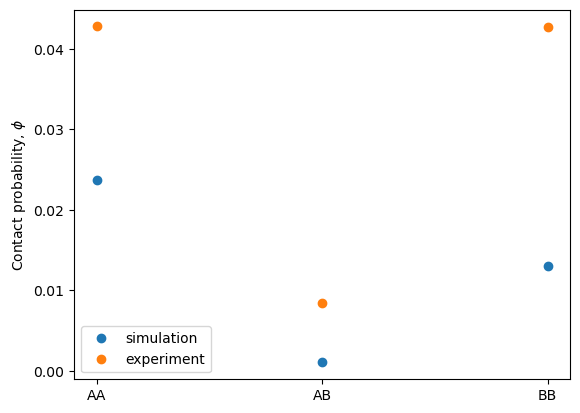

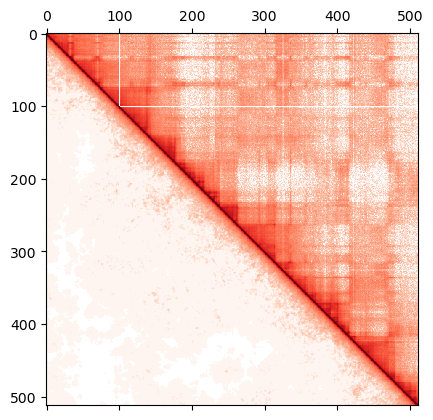

In [85]:
iteration = "0"

# Probabilities of As/Bs in the simulation and experiment
phi_sim = inversion.calc_phi_sim_types().ravel()
phi_exp = inversion.calc_phi_exp_types().ravel()

np.savetxt(osp.join(odir, 'iteration_0/phi_sim_' + iteration), phi_sim)
np.savetxt(osp.join(odir, 'iteration_0/phi_exp'), phi_exp)

plt.plot(phi_sim[phi_sim>0], 'o', label="simulation")
plt.plot(phi_exp[phi_exp>0], 'o', label="experiment")
plt.ylabel(r'Contact probability, $\phi$')
labels_exp = ["AA", "AB", "BB"]
plt.xticks(np.arange(len(labels_exp)), labels_exp)
plt.legend()

# Save and plot the simulated Hi-C
dense_sim = inversion.get_HiC_sim()
np.savetxt(osp.join(odir, 'iteration_0/hic_sim_' + iteration + '.dense'), dense_sim)

dense_exp = np.loadtxt(y_dense)
dense_exp[np.isnan(dense_exp)] = 0.0
dense_exp = normalize(dense_exp, axis=1, norm='max')
r = np.zeros(dense_sim.size).reshape(dense_sim.shape)
r = np.triu(dense_exp, k=1) + np.tril(dense_sim, k=-1) + np.diag(np.ones(len(r)))

plt.matshow(r,
            norm=mpl.colors.LogNorm(vmin=0.0001,
                                    vmax=dense_sim.max()),
            cmap="Reds")

# Save the new lambda file
lambdas.to_csv(osp.join(odir, "iteration_0/lambda_1"), index=False)